# Group 20: Morawez, Tusha, Chmielowski, Sick 
# Evolution of political parties in European parliaments over time
In this notebook, we explore how representation via political parties has evolved in European parliaments since 1995. We track how politicial parties (summarized in common party families, e.g., liberal, conservative, ecological, etc.) have won or lost vote shares in national elections and how polarization and fragmentation evolved in each country, and look for common patterns across countries. Additionally, we investigate correlations with economic and demographic country characteristics and use them to predict future election outcomes. In detail, we aim at answering the following questions:

- Which trends in election results can we observe per country?
- Which countries show similar types of change in a specific dimension at roughly the same time?
- Which commong patterns can be observed across countries?
- How well can major shifts or trends in parliamentary compositions be explained
by economic and societal conditions?
- To what extend can future parliamentary compositions be predicted by economic
and societal indicators?

In what follows, we present and explain each step of our analysis. We start with a preprocessing section, and then address each of the above research questions in its own section, with an interpretation of the most central result at each section end. At the end of the notebook, we disclose to which extent resources like LLMs were used for this exercise.


# 1. Preprocessing

## 1.1 Package imports and defining path

In [1]:
import numpy as np 
import pandas as pd 
import warnings
import re
import os
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    module=r'pandas\.io\.formats\.format'
)


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
PATH_ROOT = Path.cwd().parent
PATH_DATA = PATH_ROOT / "data"

In [ ]:
eu_country_abbreviations = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE'
}

## 1.2 Putting together the dataset
As a first step, we read in the data necessary for our analysis and combine them to a single file. This encompasses data on political parties in Europe over time (party family, vote shares, position on a left-right scale) and economic and demographic country characteristics.
### 1.2.1 Economic and demographic data
The annual **inflation rate** comes from the Harmonized Index of consumer prices (HICP) from Eurostat and depicts year-on-year changes of the average price level, harmonized for all European countries. Inflation is expected to have a strong effect on people's vote choice as price level influences people's lives directly. 


In [ ]:
# inflation rate
df_prices = pd.read_csv(PATH_DATA / 'consumer_price_index.csv', low_memory=False)
df_prices = df_prices[(df_prices['coicop'] == 'CP00') & (df_prices['unit'] == 'RCH_A_AVG')] # change in index for all items

PRICES_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_prices = df_prices[PRICES_COLUMNS]
df_prices = (
    df_prices
    .rename(columns={"OBS_VALUE": "inflation_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
# df_prices.head


The **unemployment rate** comes also from Eurostat and measures the yearly share of unemployed persons defined under ILO-standards (without work, actively seeking work, available for work) over the total labor force in the country. The unemployment rate might drive people's economic vote choice strongly as it might be correlated with lower bargaining power, higher poverty and higher crime rates.

In [ ]:
df_unemployment = pd.read_csv(PATH_DATA / 'unemployment_rate.csv', low_memory=False)
df_unemployment = df_unemployment[df_unemployment['sex'] == 'T']  # or 'total', check first

UNEMPLOYMENT_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_unemployment = df_unemployment[UNEMPLOYMENT_COLUMNS]

df_unemployment = (
    df_unemployment
    .rename(columns={"OBS_VALUE": "unemployment_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
df_unemployment.head(10)

**Poverty risk** data comes from Eurostat and is here defined as the percentage of population having an equivalized income of less than 60% of the country's median income after social transfers. Again, this might influence economic voting motives with likely similar effects as unemployment rates (higher crime rates, general economic uncertainty).

In [ ]:
df_poverty = pd.read_csv(PATH_DATA / 'poverty_risk.csv', low_memory=False)

df_poverty = (
    df_poverty
    .query("age == 'TOTAL'")  # Filter for total only
    .rename(columns={"OBS_VALUE": "poverty_risk"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "age"])
)

df_poverty = df_poverty[['geo', 'year', 'poverty_risk']].set_index(["geo", "year"])
df_poverty.head(10)


The **yearly GDP per capita growth** indicator comes from the World Bank database. It might be tied to the general economic outlook in a country, investment and production activity and, in consequence, be people finding employment and future wage raises.

In [ ]:
# yearly gdp growth 
df_gdp = pd.read_csv(PATH_DATA / 'gdp_per_cap.csv', 
                     quoting=3, 
                     engine='python', 
                     encoding='utf-8-sig',
                     on_bad_lines='skip')

df_gdp = df_gdp.reset_index()

year_columns = [str(year) for year in range(1995, 2025)]
GDP_COLUMNS = ["index", "Country Code", "Indicator Name"] + year_columns
df_gdp = df_gdp[GDP_COLUMNS]

# Filter for countries from list above
eu_country_names = list(eu_country_abbreviations.keys())
df_gdp = df_gdp[df_gdp["index"].isin(eu_country_names)]

# long format
df_gdp = df_gdp.rename(columns={"index": "country"})
df_gdp = df_gdp.melt(
    id_vars=["country", "Country Code"], 
    value_vars=year_columns,
    var_name="year", 
    value_name="gdp_per_cap"
)

df_gdp = (
    df_gdp
    .rename(columns={"Country Code": "geo_code"})
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["year"], errors='coerce').astype("Int64"))
    .assign(gdp_per_cap=lambda x: pd.to_numeric(x["gdp_per_cap"], errors='coerce'))
    .set_index(["geo", "year"])
    .drop(columns=["country", "geo_code"])
)

df_gdp.head(20)

**Wealth inequality** is measured here as the percentage of total wealth owned by the highest percentile of the wealth distribution. A higher value implies higher wealth inequality. This might impact the working population's perception of fairness and the likeliness of making a good living with one's own work - thus, impacting voting behavior.

In [ ]:
# wealth inequality
df_wealth = pd.read_csv(
    PATH_DATA / 'wealth_10p.csv',
    sep=';',
    skiprows=1, 
    on_bad_lines='skip'
) 

new_columns = {}
for col in df_wealth.columns:
    if col in ['Percentile ', 'Year ']:
        new_columns[col] = col.strip()
    else:
        # Extract country name (last part after \n)
        country_name = col.split('\n')[-1]
        new_columns[col] = country_name

df_wealth = df_wealth.rename(columns=new_columns)
df_wealth = df_wealth.drop(columns=['Percentile']) # col not needed
df_wealth = df_wealth.rename(columns={'Year': 'year'})

# Filter countries
eu_country_names = list(eu_country_abbreviations.keys())
available_eu_countries = [col for col in df_wealth.columns if col in eu_country_names]
df_wealth_eu = df_wealth[['year'] + available_eu_countries]

print(f"Found {len(available_eu_countries)} EU countries: {available_eu_countries}")

# Convert to long format
df_wealth_long = df_wealth_eu.melt(
    id_vars=['year'],
    var_name='country',
    value_name='wealth_top10_share'
)

# Convert year to integer and wealth to numeric
df_wealth_long['year'] = pd.to_numeric(df_wealth_long['year'], errors='coerce').astype('Int64')
df_wealth_long['wealth_top10_share'] = pd.to_numeric(df_wealth_long['wealth_top10_share'], errors='coerce')

# Add country code
df_wealth_long['geo'] = df_wealth_long['country'].map(eu_country_abbreviations)

# Set index
df_wealth_long = df_wealth_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_wealth_long.shape}")
df_wealth_long.head()

A country's **debt level** might not impact people's livelihoods directly but the projection of how sustainable the overall welfare system is. It is measured as debt divided by GDP and comes from the IMF's Global Debt Database.

In [ ]:
# debt to gdp ratio
df_debt = pd.read_csv(
    PATH_DATA / 'imf_debtToGdp.csv', 
    sep=';',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_debt = df_debt.rename(columns={'General Government Debt (Percent of GDP)': 'country'})

# Filter for EU countries
eu_country_names = list(eu_country_abbreviations.keys())
df_debt = df_debt[df_debt['country'].isin(eu_country_names)]

# Select only years 1995-2024
year_columns = [str(year) for year in range(1995, 2025)]
df_debt = df_debt[['country'] + year_columns]

# Convert to long format
df_debt_long = df_debt.melt(
    id_vars=['country'],
    var_name='year',
    value_name='debt_to_gdp'
)

# Convert year to integer
df_debt_long['year'] = pd.to_numeric(df_debt_long['year'], errors='coerce').astype('Int64')

# Handle the number format: keep only first decimal point, remove the rest
# 68.238.169 -> 68.238169 -> 68.2 (round to 1 decimal)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].replace('no data', None)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].astype(str).str.replace('.', '', regex=False).str[:3]  # Keep first 3 chars
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].apply(lambda x: f"{x[:-1]}.{x[-1]}" if len(x) >= 2 and x != 'Non' else None)
df_debt_long['debt_to_gdp'] = pd.to_numeric(df_debt_long['debt_to_gdp'], errors='coerce')

# Add country code
df_debt_long['geo'] = df_debt_long['country'].map(eu_country_abbreviations)

# Set index
df_debt_long = df_debt_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_debt_long.shape}")
df_debt_long.head(20)

**Immigration** is an important driver of vote choice, especially for parties with anti-immigration platforms. Data on total immigration inflow comes from Eurostat, and divided by total population (also from Eurostat) to get a relative measure of immigration.

In [ ]:
# immigration total
df_immigration = pd.read_csv(
    PATH_DATA / 'immigration_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

IMMIGRATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_immigration = df_immigration[IMMIGRATION_COLUMNS]
df_immigration = (
    df_immigration
    .rename(columns={"OBS_VALUE": "migration_inflow"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_immigration.head(20)


**Total population**, as mentioned, also comes from Eurostat and is used to calculate an indicator of relative immigration inflow.

In [ ]:
# population total
df_population = pd.read_csv(
    PATH_DATA / 'population_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

POPULATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_population = df_population[POPULATION_COLUMNS]
df_population = (
    df_population
    .rename(columns={"OBS_VALUE": "population_total"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_population.head(100)


The **dependency ratio** is another important indicator for the sustainability of a country's welfare system. It comes from Eurostat and is defined as people under 15 plus over 64 years old (non-working age) divided by the population 15 to 64 years old (working age). A higher dependency ratio therefore means that, per person of working age, there are more people dependent on the social system in some way (schooling, family benefits, pensioneers). Like other measures related to system stability (debt ratio, GDP growth), this might influence peoples voting.

In [ ]:
# dependency ratio
df_age_ratio = pd.read_csv(
    PATH_DATA / 'age_ratio.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_age_ratio = df_age_ratio[AGE_COLUMNS]
df_age_ratio = (
    df_age_ratio
    .rename(columns={"OBS_VALUE": "dependency_ratio_15_64"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_age_ratio.head(100)


The **median age** in a country is an important variable on population structure. It also comes from Eurostat.

In [ ]:
# median age 
df_median_age = pd.read_csv(
    PATH_DATA / 'median_age.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_median_age = df_median_age[AGE_COLUMNS]
df_median_age = (
    df_median_age
    .rename(columns={"OBS_VALUE": "median_age"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_median_age.head(100)


A country population's **educational attainment** levels are also important predictors: Low general levels might lead to stronger support more populist parties. Here, educational attainment is measured by the population percentage of people with tertiary education according to ISCED 2011 (university level). The complement to 100% is, consequently, the share of the population with lower educational attainment. The data comes from Eurostat.

In [ ]:
# educational attainment
df_education = pd.read_csv(
    PATH_DATA / 'educational_attainment.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_education = (
    df_education
    .query("`International Standard Classification of Education (ISCED 2011)` == 'Tertiary education (levels 5-8)'")
    .rename(columns={
        "OBS_VALUE": "Tertiary education",
        "Geopolitical entity (reporting)": "country"
    })
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    [['geo', 'year', 'Tertiary education']]
    .set_index(['geo', 'year'])
)

df_education.head(10)


The share of population living in **urban conditions** might influence how voters thing about agricultural and environmental issues. The data comes from the World Bank database.

In [ ]:
# urban population
df_urban = pd.read_csv(
    PATH_DATA / 'urban_population.csv', 
    sep=',',
    encoding='utf-8-sig',
    skiprows=4,
    quoting=3,
    engine='python',
    on_bad_lines='skip'
)

# clean up some stuff
df_urban = df_urban.reset_index()
df_urban.columns = df_urban.columns.str.replace('"', '', regex=False)
df_urban = df_urban.apply(lambda x: x.str.replace('"', '', regex=False) if x.dtype == 'object' else x)
df_urban = df_urban.rename(columns={'index': 'country'})

# Filter for countries and years
eu_country_names = list(eu_country_abbreviations.keys())
df_urban = df_urban[df_urban['country'].isin(eu_country_names)]
year_columns = [str(year) for year in range(1995, 2025)]
df_urban = df_urban[['country'] + year_columns]

# Convert to long
df_urban_long = df_urban.melt(
    id_vars=['country'],
    var_name='year',
    value_name='urban_population_pct'
)
df_urban_long['year'] = pd.to_numeric(df_urban_long['year'], errors='coerce').astype('Int64')
df_urban_long['urban_population_pct'] = pd.to_numeric(df_urban_long['urban_population_pct'], errors='coerce')


df_urban_long['geo'] = df_urban_long['country'].map(eu_country_abbreviations)
df_urban_long = df_urban_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"Final shape: {df_urban_long.shape}")
df_urban_long.head(20)

## 1.2.2 Manifesto project
The **Manifesto project** is a joint effort by Political Scientists of the Berlin Social Science Center to extract quantitative data on political parties (e.g., factual position on a left-right scale, their substantive positions of various topics) from party manifesto texts in all European and many other countries. Included are parties that ran for national elections and gathered at least one seat in parliament (with some exceptions, see [here](https://manifestoproject.wzb.eu/questions)). The dataset also includes the vote shares for each party at each election, and categorizes parties into larger "party families". For this project, we make use of these data to measure vote shares by party (and later aggregated to party family vote shares), left-right positioning of parties (to measure overall polarization in the country) and number of parties (to measure party fragmentation). 

In the cell below, these data are loaded, columns and party family codes are renamed and relevant countries are selected.

In [ ]:
# read data
manifesto = pd.read_csv(
    PATH_DATA / 'manifesto.csv', 
    sep=',',
    encoding='utf-8-sig',
    engine='python',
    on_bad_lines='skip'
)

# select columns
MANIFESTO_COLUMNS = ['countryname', 
                     'edate', 
                     'partyname', 
                     'pervote', 
                     'party', 
                     'parfam', 
                     'rile', 
                     'planeco', 
                     'welfare', 
                     'markeco', 
                     'per107', 
                     'per202', 
                     'per416_2']

manifesto = manifesto[MANIFESTO_COLUMNS]

# renaming columns
renaming_map = {
    'partyname': 'party_name',
    'pervote': 'vote_share_percent',
    'countryname': 'country',
    'edate': 'election_date',
    'party': 'party_code',
    'rile': 'right_left_position',
    'planeco': 'planned_economy',
    'welfare': 'welfare_state',
    'markeco': 'market_economy',
    'per107': 'inter_positive',
    'per202': 'democracy',    
    'per416_2': 'sustainability_positive',  
}

# renaming party families
PARFAM = {
    10:  {"abbreviations": "ECO", "label": "Ecological parties"},
    20:  {"abbreviations": "LEF", "label": "Socialist or other left parties"},
    30:  {"abbreviations": "SOC", "label": "Social democratic parties"},
    40:  {"abbreviations": "LIB", "label": "Liberal parties"},
    50:  {"abbreviations": "CHR", "label": "Christian democratic parties (in Israel also Jewish parties)"},
    60:  {"abbreviations": "CON", "label": "Conservative parties"},
    70:  {"abbreviations": "NAT", "label": "Nationalist and radical right parties"},
    80:  {"abbreviations": "AGR", "label": "Agrarian parties"},
    90:  {"abbreviations": "ETH", "label": "Ethnic and regional parties"},
    95:  {"abbreviations": "SIP", "label": "Special issue parties"},
    98:  {"abbreviations": "DIV", "label": "Electoral alliances of diverse origin without dominant party"},
    999: {"abbreviations": "MI",  "label": "Missing information"},
}
manifesto =manifesto.rename(columns=renaming_map)

manifesto["election_date"] = pd.to_datetime(
    manifesto["election_date"], 
    format='%d/%m/%Y', 
    errors='coerce' 
)           
manifesto["parfam_code"] = manifesto["parfam"].map({k: v["abbreviations"] for k, v in PARFAM.items()})
manifesto["parfam_label"] = manifesto["parfam"].map({k: v["label"] for k, v in PARFAM.items()})

# chose European countries
eu_countries = [
    'Austria',
    'Belgium',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czechia',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Ireland',
    'Italy',
    'Latvia',
    'Lithuania',
    'Luxembourg',
    'Malta',
    'Netherlands',
    'Poland',
    'Portugal',
    'Romania',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Sweden'
]
manifesto = manifesto.loc[manifesto["country"].isin(eu_countries)].copy()
manifesto["geo"] = manifesto["country"].map(eu_country_abbreviations)
manifesto["election_date"] = pd.to_datetime(manifesto["election_date"])
manifesto["year"] = manifesto["election_date"].dt.year
manifesto.head(10)


In order to meaningfully merge the data from the Manifesto dataset (one row for every country-election date-party combination) with the data on economic and demographic characteristics (with rows for every country and every year), we need to inflate the Manifesto dataset to have rows for every year, too. This is done in the follwing cell by defining *between-election segments* and copying the content of the corresponding country-election date-party combination into these segments. The election date marks the beginning of each segment (e.g, the Ausrian National Election of 1995 for the segment 1995 - 1999), through which party positions and vote share of the most last election are perceived as the most recent values for this period. For each country-election date-party combination, values from the last election before 2024 are "filled up" to 2024. 

At the end of the following cell, the relevant time frame used in this project is selected (1995-2024). This is from when the most economic and demographic data is available for every country.

In [ ]:
manifesto = manifesto.sort_values(['geo', 'election_date'])
END_YEAR = 2024

# get all election years per country
election_years_by_country = manifesto.groupby('geo')['year'].apply(lambda x: sorted(x.unique())).to_dict()

def fill_years(group, geo, party_code):
    group = group.copy()
    group['year'] = group['year'].astype(int)
    group = group.drop_duplicates(subset=['year'])
    
    country_elections = election_years_by_country[geo]
    party_election_years = sorted(group['year'].tolist())
    
    # build segments: only fill between consecutive elections where party ran
    segments = []
    for i, start_year in enumerate(party_election_years):
        next_country_elections = [y for y in country_elections if y > start_year]
        
        if i + 1 < len(party_election_years):
            next_party_election = party_election_years[i + 1]
            elections_between = [y for y in next_country_elections if y < next_party_election]
            if elections_between:
                end_year = elections_between[0]
            else:
                end_year = next_party_election
        else:
            if next_country_elections:
                end_year = next_country_elections[0]
            else:
                end_year = END_YEAR + 1
        
        segments.append((start_year, end_year))
    
    # build the filled dataframe from segments
    filled_dfs = []
    for start_year, end_year in segments:
        segment_data = group[group['year'] == start_year].copy()
        full_years = pd.RangeIndex(start_year, end_year, name='year')
        segment_data = segment_data.set_index('year').reindex(full_years)
        segment_data['geo'] = geo
        segment_data['party_code'] = party_code
        segment_data = segment_data.ffill()
        filled_dfs.append(segment_data.reset_index())
    
    return pd.concat(filled_dfs, ignore_index=True)

# Apply
manifesto = manifesto.dropna(subset=['vote_share_percent']) # remove parties with NAN vote share (the changed name or ran in coalitions, might be double-counted otherwise)
manifesto_filled = (
    manifesto
    .groupby(['geo', 'party_code'], group_keys=False)
    .apply(lambda g: fill_years(g, g.name[0], g.name[1]), include_groups=False)
)
manifesto_filled = manifesto_filled.sort_values(['geo', 'year', 'party_name']).reset_index(drop=True)

# filter relevant year range
manifesto_filled = manifesto_filled.query('1995 <= year <= 2024')


## 1.2.3 Merging datasets
In the cell below, all datasets (Manifesto data, economic and demographic data) are merged to one.

In [ ]:
right_dfs = [df_poverty, 
             df_gdp, 
             df_prices, 
             df_unemployment, 
             df_age_ratio,
             df_debt_long,
             df_education,
             df_immigration,
             df_median_age,
             df_population,
             df_urban_long,
             df_wealth_long]

manifesto_final = manifesto_filled.set_index(["geo", "year"])
df = manifesto_final

# Perform sequential left merges
for right_df in right_dfs:
    # Remove duplicates from right dataframe before merging
    right_df_clean = right_df[~right_df.index.duplicated(keep='first')]
    
    df = pd.merge(
        left=df,
        right=right_df_clean,
        how='left',
        left_index=True, 
        right_index=True,                  
        suffixes=('', '_new_data')        
    )
df = df.sort_index(level=['geo', 'year'])

# calculate the relative migration indicator (total immigration divided by total population)
df["rel_immigration"] = 100*df["migration_inflow"]/df["population_total"]
df = df.drop(columns = ["population_total", "migration_inflow"])

df.head()

In some rare cases, a country had two elections in the same year. This creates problems when trying to add upp vote shares accross parties for one year, because it leads to double counting. As a major focus of this project is to investigate how important economic and demographic factors contribute to a party family's *subsequent* success in elections in Europe (both in a descriptive analysis and in prediction), we decided to only keep the first election in these cases. Second elections in the same year are typically a sign of coalition infighting and scandals and might not reflect the effect of said economic and demgraphic factors. 

In addition, for one specific case, party code 34212 had to be removed manually from the dataset from 2012 onwards (SYRIZA in Greece), as this party joined a coalition in that year and was assigned a different party_code from the second election onwards. This is not picked up by drop_duplicates because of different party codes, which might lead to double counting.

In [ ]:
# Deduplicate and remove SYRIZA
df = df.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'year', 'party_code'], keep='first'
).set_index(['geo', 'year'])

df = df.reset_index()
df = df[~((df['geo'] == 'GR') & 
          (df['year'] >= 2012) & 
          (df['party_code'] == 34020))]
df = df.set_index(['geo', 'year'])

The following cell extracts the vote shares for every election by party family. That is, for every national election in every country, votes for partys belonging to the same party family are added up and provided in wide format. Also, a fragmentation index (how fragmented is the party landscape) and a polarization index (based on the left-right indicator from Manifesto) is calculated.

In [ ]:
"""

def election_df(df):
        
    d = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    d = (d.dropna(subset=["geo","election_date","party_code","vote_share_percent"])
           .groupby(["geo","election_date","party_code"], as_index=False)
           .agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_score=("right_left_position","first")))

    d["vote share proportion"] = d["voteshare"] / 100.0

    # vote shares by party family
    fam = (d.groupby(["geo","election_date","parfam"])["voteshare"]
             .sum()
             .unstack(fill_value=0)
             .add_prefix("vs_"))

    # fragmentation ENP
    enp = d.groupby(["geo","election_date"])["vote share proportion"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    # Dalton polarization
    def dalton(g):
        g = g.dropna(subset=["vote share proportion","lr_score"])
        w, lr_score = g["vote share proportion"].to_numpy(), g["lr_score"].to_numpy()
        return np.nan if len(w) == 0 else float(np.sqrt((w * ((lr_score - (w*lr_score).sum()/w.sum()) / 5)**2).sum()))
    
    pol = (d.groupby(["geo", "election_date"])[["vote share proportion", "lr_score"]].apply(dalton).rename("polarization_dalton"))
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(df)

# deduplicate
elections = elections.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'election_year'], keep='first'
).set_index(['geo', 'election_year']).sort_index()

elections.head()
"""

## 1.3 Dealing with missings
First, we create an overview of prevalence and distribution of missings.

In [ ]:
# count and percentage of missings per column
missing_summary = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('missing_pct', ascending=False)

missing_summary[missing_summary['missing_count'] > 0]

Note that missings in Manifesto data (planned economy, sustainability) are permissible because this simply means that this party did not talk these topics in their manifestos. They can be left as is. More attention needs to be put on economic and demographic data. Below, we see how prevalent these missings are in each country.

In [ ]:
# Columns to check (only those with missings)
socioeco_vars = ['poverty_risk', 
                 'rel_immigration',
                 'gdp_per_cap',
                 'urban_population_pct',
                 'inflation_rate',
                 'unemployment_rate',
                 'Tertiary education',
                 'debt_to_gdp',
                 'dependency_ratio_15_64',
                 'median_age']

missing_by_country = (df.reset_index()
    .groupby('geo')[socioeco_vars]
    .apply(lambda x: x.isna().mean() * 100)
    .round(1)
)
missing_by_country = missing_by_country.T
missing_by_country = missing_by_country.loc[:, (missing_by_country > 0).any()]
missing_by_country

It appears that especially poverty risk and immigration has many missings, and that especially Greece and Slovakia has poor data coverage for economic and demographic data. Next, we look if these variables are missing completely at random (MCAR), at random (MAR) or not at random (MNAR). The test below measures of missingness of variables is related to other variables (MAR).

In [ ]:
# MAR test
def test_mar_all(df, test_cols):
    from scipy import stats
    
    results = []
    for test_col in test_cols:
        missing_mask = df[test_col].isna()
        
        # skip if no missings
        if missing_mask.sum() == 0:
            continue
            
        for compare_col in test_cols:
            if compare_col == test_col:
                continue
                
            group_missing = df.loc[missing_mask, compare_col].dropna()
            group_observed = df.loc[~missing_mask, compare_col].dropna()
            
            if len(group_missing) > 5 and len(group_observed) > 5:
                stat, pval = stats.ttest_ind(group_missing, group_observed)
                results.append({
                    'missing_var': test_col,
                    'compared_var': compare_col,
                    'mean_when_missing': round(group_missing.mean(), 2),
                    'mean_when_observed': round(group_observed.mean(), 2),
                    'mean_diff': round(group_observed.mean() - group_missing.mean(), 2),
                    'p_value': round(pval, 4),
                    'significant': pval < 0.05
                })
    
    return pd.DataFrame(results).sort_values('p_value')

# Run for all variables
mar_results = test_mar_all(df.reset_index(), socioeco_vars)

# Show only significant results
mar_results[mar_results['significant']]

It seems that most missings are MAR, i.e., dependent on other variables. It is therefore possible to deal with missing values with interpolation and imputation. For this, we choose a two step approach: First, interpolation and extrapolation where possible, then imputation of remaining gaps using other variables. Poverty risk is dropped completely from the data as 17% is missing (see above), imputation is therefore likely not reliable.

In [ ]:
df = df.drop(columns='poverty_risk')
socioeco_vars = [var for var in socioeco_vars if var != 'poverty_risk']

# save for later comparison
missing_mask_original = df[socioeco_vars].isna().copy()

# Get one row per country-year for socioeco vars
country_year = df.reset_index().drop_duplicates(['geo', 'year'])[['geo', 'year'] + socioeco_vars].copy()
country_year = country_year.sort_values(['geo', 'year']).set_index(['geo', 'year'])

# Interpolate (inside gaps up to 5 values)
country_year[socioeco_vars] = country_year.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='inside', limit=5))

# extrapolate (outside up to 3 values)
country_year[socioeco_vars] = country_year.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='outside', limit=3, limit_direction='both'))

# Check remaining missings
print("missings after interpolation/extrapolation:")
print(country_year[socioeco_vars].isna().sum())

# Impute remainder gaps
if country_year[socioeco_vars].isna().any().any():
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    imputer = IterativeImputer(random_state=42, max_iter=10)
    country_year[socioeco_vars] = imputer.fit_transform(country_year[socioeco_vars])

# Merge back
df = df.drop(columns=socioeco_vars)
df = df.merge(country_year, left_index=True, right_index=True)

# Save missing mask at country-year level for visualization
missing_mask = missing_mask_original.reset_index().drop_duplicates(['geo', 'year']).set_index(['geo', 'year'])

Quick check if it worked:

In [ ]:
# number of missings
print("Missings after imputation")
print(df[socioeco_vars].isna().sum())

In [ ]:
from ipywidgets import interact, Dropdown

def plot_with_imputation_markers(var, geo):
    data = country_year.loc[geo, var].sort_index()
    was_missing = missing_mask.loc[geo, var].sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(data.index, data.values, 'b-', marker='o', label='Data')
    imputed_idx = was_missing[was_missing].index
    if len(imputed_idx) > 0:
        ax.scatter(imputed_idx, data.loc[imputed_idx], color='red', s=100, zorder=5, label='Imputed')
    
    ax.set_xlabel('Year')
    ax.set_ylabel(var)
    ax.set_title(f'{var} in {geo} (red = imputed)')
    ax.legend()
    plt.tight_layout()
    plt.show()

countries = sorted(country_year.reset_index()['geo'].unique())

interact(
    plot_with_imputation_markers,
    var=Dropdown(options=socioeco_vars, value=socioeco_vars[0], description='Variable:'),
    geo=Dropdown(options=countries, value='DE', description='Country:'))

# Research Question 1: 
## How have parliamentary compositions in European countries evolved over time and what major shifts or trends can be observed?

Outline: 

1. Data Preparation for Trend Analysis

2. Trend Analysis

3. Results

## Data preparation for Trend Analysis: Analysis Dataframe

For our analysis, we transform the Manifesto election data into an election dataframe, that for each country x election stores:

1. Party-family vote shares

2. Fragmentation index (Operationalization: Laakso et al., see [Effective number of parties, Quadratic](https://en.wikipedia.org/wiki/Effective_number_of_parties) (ENP)) using normalized vote shares
	
3. Polarization index (Operationalization: Dalton, see [Polarization Index](https://felixgruenewald.gitlab.io/encyclopediaofpolarization/measures/polarization-index/)) from party left–right positions weighted by normalized vote shares

This dataframe enables our Trend Analysis per country (RQ 1), which we will later use to analyze cross country trends (RQ 2).

Note: The Dalton polarization index normalizes ideological dispersion by half of the theoretical left–right scale range. While the original formulation assumes a 0–10 left–right scale (implying a denominator of 5), our left–right positions from the Manifesto Project (RILE) are theoretically bounded in [−100, +100]. We therefore normalize the polarization index by the corresponding half-range (100).

In [ ]:
def election_df(df):
    """
    for each country x election, computes:
        vote shares by party family, 
        the fragmentation index (effective number of parties (ENP))
        and Dalton polarization index.
    """
        
    election_data = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    election_data = (election_data.dropna(subset=["geo","election_date","party_code","vote_share_percent"]).groupby(["geo","election_date","party_code"], as_index=False).agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_scores=("right_left_position","first")))

    # normalize voteshares for fragmentation / polarization computation
    election_data["vote_share_proportion"] = election_data["voteshare"] / 100.0
    total = election_data.groupby(["geo","election_date"])["vote_share_proportion"].transform("sum")
    election_data["vote_share_normalized"] = np.where(total > 0, election_data["vote_share_proportion"] / total, np.nan)

    # vote shares by party family
    fam = (election_data.groupby(["geo","election_date","parfam"])["voteshare"].sum().unstack(fill_value=0).add_prefix("vs_"))

    # fragmentation index (ENP)
    enp = election_data.groupby(["geo","election_date"])["vote_share_normalized"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    def dalton(election_parties):
        """
        Polarization index (Dalton)
        """
        election_parties = election_parties.dropna(subset=["vote_share_normalized", "lr_scores"])

        # Left–right (RILE) scale from Manifesto Project
        LR_LOWER = -100.0
        LR_UPPER = 100.0
        # denominator normalizes by half of the theoretical scale range
        LR_DENOMINATOR = (LR_UPPER - LR_LOWER) / 2 # 100

        vote_weights = election_parties["vote_share_normalized"].to_numpy()
        lr_scores = election_parties["lr_scores"].to_numpy()

        if len(vote_weights) == 0:
            return np.nan

        weighted_mean_lr = (vote_weights * lr_scores).sum() / vote_weights.sum()
        polarization = np.sqrt((vote_weights * ((lr_scores - weighted_mean_lr) / LR_DENOMINATOR) ** 2).sum()) # range: [0, 0.3]

        return float(polarization)
    
    # compute polarization index per country x election
    pol = (election_data.groupby(["geo", "election_date"])[["vote_share_normalized", "lr_scores"]].apply(dalton).rename("polarization_dalton"))

    # combine results into one election x country level dataframe
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(df)

# deduplicate
elections = elections.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'election_year'], keep='first'
).set_index(['geo', 'election_year']).sort_index()

elections.head()

## Data preparation for Trend Analysis: Inter-election change distributions and epsilon calibration

Later, trend episodes will be classified as up, down or flat based on inter-election changes. To classify flat changes, we compute an **epsilon** (small change tolerance) per variable type:

1. Vote shares (vs_*) in percentage points

2. Fragmentation (fragmentation_enp) in ENP units

3. Polarization (polarization_dalton) in Dalton units

For each country, we compute absolute inter-election changes, pool them across countries, take the median of absolute change, then define:

- epsilon = 0.2 x median of change (vs, fragmentation or polarization)

Note: For most elections, many party-families are not present and thus voteshares are zero. Therefore, zeros are excluded from median computation.

In [ ]:
def absolute_step_changes(df_country_year: pd.DataFrame) -> pd.Series:
    """
    for one country:
        compute pooled absolute election-election changes
    """
    step_deltas = df_country_year.sort_index().diff()  
    return step_deltas.abs().stack().dropna()

# voteshare columns
vs_cols = [c for c in elections.columns if c.startswith("vs_")]
if len(vs_cols) == 0:
    raise ValueError("No vote share columns found")

# compute change distributions per variable type
vs_deltas = []
enp_deltas = []
pol_deltas = []

for geo, country_ts in elections.groupby(level=0):
    country_ts = country_ts.droplevel(0) # election year index

    vs_deltas.append(absolute_step_changes(country_ts[vs_cols]))
    enp_deltas.append(absolute_step_changes(country_ts[["fragmentation_enp"]]))
    pol_deltas.append(absolute_step_changes(country_ts[["polarization_dalton"]]))

vs_deltas = pd.concat(vs_deltas, ignore_index=True)
enp_deltas = pd.concat(enp_deltas, ignore_index=True)
pol_deltas = pd.concat(pol_deltas, ignore_index=True)

# median changes, but ignore zero voteshare (e.g. party family not present) changes
vs_deltas_nonzero = vs_deltas[vs_deltas > 0]
med_vs = float(vs_deltas_nonzero.median())
med_enp = float(enp_deltas.median())
med_pol = float(pol_deltas.median())

# compute epsilon (small change tolerance: "noise") per variable type
epsilon_multiplier = 0.2
epsilon_vs = med_vs * epsilon_multiplier
epsilon_enp = med_enp * epsilon_multiplier
epsilon_pol = med_pol * epsilon_multiplier

print("\nMedian change and epsilons:")
print(f"Vote shares (vs_*): median change = {med_vs:.3f} => epsilon_vs = {epsilon_vs:.3f}")
print(f"Fragmentation (ENP): median change = {med_enp:.3f} => epsilon_enp = {epsilon_enp:.3f}")
print(f"Polarization (Dalton): median change = {med_pol:.3f} => epsilon_pol = {epsilon_pol:.3f}")

# diagnostic plots: distributions of change with epsilon marker
def plot_abs_delta_hist(abs_deltas: pd.Series, eps: float, title: str, xlabel: str, bins: int = 50):
    plt.figure(figsize=(8, 4))
    plt.hist(abs_deltas, bins=bins, density=True)
    plt.axvline(eps, linewidth=2, label=f"epsilon = {eps:.3g}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_abs_delta_hist(vs_deltas, epsilon_vs, "Vote shares (vs_*) change distribution", "absolute change (percentage points)")
plot_abs_delta_hist(enp_deltas, epsilon_enp, "Fragmentation (ENP) change distribution", "absolute change (ENP units)")
plot_abs_delta_hist(pol_deltas, epsilon_pol, "Polarization (Dalton) change distribution", "absolute change (Dalton units)")

# Analysis: Trend episode detection for all countries

For each country and each variable (party-family vote shares, fragmentation and polarization), we search the election time series for trend episodes from 1995. 

- Trend episode = a maximal time window of continuous inter-election steps that move in the same direction (up or down) for at least two transitions (3 elections), ignoring small changes (within variable specific epsilons) treated as "noise" (flat).

In [ ]:
def detect_all_trends(elections: pd.DataFrame, epsilon_vs: float, epsilon_enp: float, epsilon_pol: float, start_year: int = 1995, min_transitions: int = 2):
    """
    for each country x elections:
        determines all trends, max of consecutive same direction changes, starting from start_year with a minimum of 2 transitions (3 elections).
    """

    # var list
    vs_cols = [c for c in elections.columns if c.startswith("vs_")]
    variables = vs_cols + ["fragmentation_enp", "polarization_dalton"]

    # epsilon look-up
    eps = {c: epsilon_vs for c in vs_cols} | {
        "fragmentation_enp": epsilon_enp,
        "polarization_dalton": epsilon_pol,
    }

    def episodes(years, values, epsilon):
        """
        Detect trend episodes in a single time series
        """
        # classify election-election change
        step_deltas = np.diff(values) 
        step_labels = np.full(step_deltas.shape, "flat", dtype=object)
        step_labels[step_deltas >  epsilon] = "up"
        step_labels[step_deltas < -epsilon] = "down" 

        # find all trend episodes
        found, n_steps, i = [], len(step_deltas), 0
        while i < n_steps:

            # skip flat changes
            if step_labels[i] == "flat":
                i += 1
                continue

            # continuous same direction windows
            direction = step_labels[i] # up or down
            j = i
            while j + 1 < n_steps and step_labels[j + 1] == direction:
                j += 1

            # minimum transitions filter
            if (j - i + 1) >= min_transitions:

                # trend episode values
                episode_values = values[i : j + 2]
                episode_steps = step_deltas[i : j + 1]
                total_change = float(episode_values[-1] - episode_values[0])
                
                # (store) trend episode stats
                found.append({
                        "start_year": int(years[i]),
                        "end_year": int(years[j + 1]),
                        "start_value": float(episode_values[0]),
                        "end_value": float(episode_values[-1]),
                        "n_elections": int(j - i + 2),
                        "direction": direction,
                        "mean_slope": float(total_change / (len(episode_values) - 1)),
                        "peak_slope": float(episode_steps[np.argmax(np.abs(episode_steps))]),
                        "total_change": total_change,
                    })

            # continue search
            i = j + 1

        return found

    # for all countries x variables
    rows = []
    for geo, country_ts in elections.groupby(level=0):

        # election year index (country-level), filter years
        country_ts = country_ts.droplevel(0).sort_index()
        country_ts = country_ts[country_ts.index >= start_year]

        # per var
        for v in variables:
            ts = country_ts[v].dropna()
            if len(ts) < (min_transitions + 1):  # transitions = elections-1
                continue

            yrs = ts.index.to_numpy()
            values = ts.to_numpy(dtype=float)

            # find trend episodes 
            for ep in episodes(yrs, values, eps[v]):
                rows.append({
                "geo": geo,
                "variable": v,
                 "var_type": "vs" if v.startswith("vs_") else ("enp" if v == "fragmentation_enp" else "pol"),
                 **ep
                })

    return (pd.DataFrame(rows).sort_values(["variable", "geo", "start_year"]).reset_index(drop=True))

episodes = detect_all_trends(elections, epsilon_vs=epsilon_vs, epsilon_enp=epsilon_enp, epsilon_pol=epsilon_pol, start_year=1993, min_transitions=2)
episodes.head()

# Trend analysis: Country-level visualization and overview of trends

For visual inspection, we build an interactive view to inspect each country’s election series:

1. Stacked area chart of party-family vote shares.

2. Fragmentation (ENP) and Polarization (Dalton), with colorized trends and flat steps.

For each country, we provide an overview with the largest episodes (ranked by absolute total change).

In [ ]:
# party family color palette
FAMILY_COLORS = {
    "vs_SOC": "#e41a1c",   # Social democratic parties
    "vs_LEF": "#7f0000",   # Socialist or other left parties
    "vs_ECO": "#4daf4a",   # Ecological parties
    "vs_LIB": "#ffb000",   # Liberal parties
    "vs_CHR": "#000000",   # Christian democratic parties
    "vs_CON": "#377eb8",   # Conservative parties
    "vs_NAT": "#6a3c03",   # Nationalist and radical right parties
    "vs_AGR": "#b68528",   # Agrarian parties
    "vs_ETH": "#1fbfcf",   # Ethnic and regional parties
    "vs_SIP": "#984ea3",   # Special issue parties
    "vs_DIV": "#bdbdbd"    # Electoral alliances
}

# direction colors
DIR_COLOR = {"up": "green", "down": "red", "flat": "gray"}

def shade_episodes(ax, episodes_df, alpha=0.22):
    """
    shades trend episodes in graphics
    """
    for _, r in episodes_df.iterrows():
        ax.axvspan(r.start_year, r.end_year, alpha=alpha, color=DIR_COLOR.get(r.direction, "gray"))

def top_episodes(episodes_df, k):
    """
    return top trend episodes table
    """
    if episodes_df.empty:
        return episodes_df
    return (episodes_df.assign(impact=episodes_df["total_change"].abs()).sort_values("impact", ascending=False).head(k)[["variable","direction","start_year","end_year","mean_slope","peak_slope","total_change"]])

def shade_flat_steps(ax, series: pd.Series, eps: float, alpha=0.10):
    """
    shades flat steps in graphics
    """
    series = series.dropna().sort_index()
    yrs = series.index.to_numpy()
    values = series.to_numpy(dtype=float)
    if len(values) < 2:
        return
    step_deltas = np.diff(values)
    for k in range(len(step_deltas)):
        if abs(step_deltas[k]) <= eps:
            ax.axvspan(int(yrs[k]), int(yrs[k+1]), alpha=alpha, color="gray")

def plot_country(geo, elections, episodes, epsilon_enp, epsilon_pol, start_year=1995, top_vs=10, top_enp=3, top_pol=3):
    """
    for each country:
        plot stacked area chart of vote shares over time and a time series of fragmentation and polarization
    """
    fam = [c for c in elections.columns if c.startswith("vs_")]
    cols = fam + ["fragmentation_enp", "polarization_dalton"]

    # filter 
    country_ts = elections.loc[geo, cols].copy()
    country_ts = country_ts[country_ts.index >= start_year].sort_index()
    country_episodes = episodes[(episodes.geo == geo) & (episodes.start_year >= start_year)].copy()

    vs_episodes  = country_episodes[country_episodes["variable"].str.startswith("vs_")]
    enp_episodes = country_episodes[country_episodes["variable"].eq("fragmentation_enp")]
    pol_episodes = country_episodes[country_episodes["variable"].eq("polarization_dalton")]

    # plot stacked area vote shares
    fig, ax = plt.subplots(figsize=(11, 5))
    country_ts[fam].plot.area(
        stacked=True, alpha=0.9, ax=ax,
        color=[FAMILY_COLORS[c] for c in fam],
        title=f"{geo}: Vote shares by party family"
    )
    ax.set_xlabel("Election year"); ax.set_ylabel("Vote share (%)")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Party family")
    plt.tight_layout()
    plt.show()

    # show top vote share episodes
    tab_vs = top_episodes(vs_episodes, top_vs).copy()
    if not tab_vs.empty:
        tab_vs["variable"] = tab_vs["variable"].str.replace("^vs_", "", regex=True)
    print(f"{geo} — Top vote-share episodes")
    display(tab_vs)

    # plot fragmentation index
    fig, ax = plt.subplots(figsize=(11, 3))
    country_ts["fragmentation_enp"].plot(ax=ax, title=f"{geo}: Fragmentation (ENP)")
    shade_episodes(ax, enp_episodes)
    shade_flat_steps(ax, country_ts["fragmentation_enp"], epsilon_enp)
    ax.set_xlabel("Election year"); ax.set_ylabel("ENP")
    plt.tight_layout()
    plt.show()

    print(f"{geo} — Top ENP episodes")
    display(top_episodes(enp_episodes, top_enp))

    # plot polarization index
    fig, ax = plt.subplots(figsize=(11, 3))
    country_ts["polarization_dalton"].plot(ax=ax, title=f"{geo}: Polarization (Dalton)")
    shade_flat_steps(ax, country_ts["polarization_dalton"], epsilon_pol)  
    shade_episodes(ax, pol_episodes)
    ax.set_xlabel("Election year"); ax.set_ylabel("Polarization")
    plt.tight_layout()
    plt.show()

    print(f"{geo} — Top polarization episodes")
    display(top_episodes(pol_episodes, top_pol))


# Interactive UI widget

import ipywidgets as w

# country view options (one, multiple, all)
all_geos = sorted(elections.index.get_level_values(0).unique())
mode = w.ToggleButtons(options=["Selected", "All"], value="Selected", description="Mode")
geo_sel = w.SelectMultiple(options=all_geos, value=(all_geos[0],), description="Countries", rows=10)

# slider
top_vs_w  = w.IntSlider(value=8, min=1, max=20, step=1, description="Top vs_*")
top_enp_w = w.IntSlider(value=3, min=1, max=10, step=1, description="Top ENP")
top_pol_w = w.IntSlider(value=3, min=1, max=10, step=1, description="Top Pol")

out = w.Output()

# run widget
def _run(*_):
    with out:
        clear_output(wait=True)
        geos = all_geos if mode.value == "All" else list(geo_sel.value)
        for geo in geos:
            plot_country(
                geo, elections=elections, episodes=episodes,
                epsilon_enp=epsilon_enp, epsilon_pol=epsilon_pol,
                top_vs=top_vs_w.value, top_enp=top_enp_w.value, top_pol=top_pol_w.value
            )

# event detection
for widget in [mode, geo_sel, top_vs_w, top_enp_w, top_pol_w]:
    widget.observe(_run, names="value")

# display and run
display(w.HBox([w.VBox([mode, geo_sel]), w.VBox([top_vs_w, top_enp_w, top_pol_w])]))
display(out)
_run()

# Trend analysis results

For RQ1 insights, we summarize all trend episodes by variable (party-family voteshares, fragmentation and polarization) x direction to extract patterns. Further, we manually inspect slow long-term shifts, that are not captured by our consecutive directional (major) shift detection.

Our operationalized summary aggregates detected trend episodes and reports:
- How often do such episodes occur?
- For how many countries do they appear?
- What is their typical duration and magnitude?

In [ ]:
eps = episodes.copy()

# additional metrics
eps["duration_years"] = eps["end_year"] - eps["start_year"]
eps["abs_total_change"] = eps["total_change"].abs()

# summary
rq1_var_dir_summary = (
    eps.groupby(["variable", "var_type", "direction"], as_index=False)
       .agg(
           n_episodes=("geo", "count"),
           n_countries=("geo", "nunique"),
           median_duration_years=("duration_years", "median"),
           median_abs_change=("abs_total_change", "median"),
           max_abs_change=("abs_total_change", "max"),
       ).sort_values(["n_countries", "median_abs_change"], ascending=False))

display("RQ1: Episode patterns by variable x direction", rq1_var_dir_summary)

## Result summary:

# Research Question 2:

## Can we identify groups of countries that show similar major shifts in parliamentary compositions?

Outline:

1. Analysis: EU-wide shared trend episode detection

2. Results: Analysis of shared trend episodes

# Analysis: EU-wide shared trend episode detection

Shared trend episodes are defined as multiple countries exhibit the same trend at the same time. 

For each variable (party family voteshare, fragmentation or polarization) x direction (up, down or flat), we find maximal time windows where the same set of countries simultaneously have the same trend.

For this, we use a sweep-line approach over trend episodes start/end years to detect overlap windows. For each overlap window, we also produce summary statistics.

In [ ]:
def find_group_overlaps(episodes: pd.DataFrame, min_countries: int = 2):
    """
    For each variable x direction: find all maximal time windows, where countries share the same trend. 
    """

    # needed cols
    episodes_df = episodes[["geo","variable","var_type","direction","start_year","end_year","total_change","mean_slope","peak_slope"]].copy()

    rows = []
    # per variable x direction
    for (var, direction), group in episodes_df.groupby(["variable", "direction"]):

        # build start / end boundary events
        boundary_events = []
        for r in group.itertuples(index=False):
            boundary_events.append((r.start_year, +1, r.geo)) # +1 = active from this year
            boundary_events.append((r.end_year, -1, r.geo)) # -1 = inactive from this year
        boundary_events.sort(key=lambda x: (x[0], x[1])) # sort: 1. year, 2. inactive before active

        active_countries = set()
        last_year = None

        # summarize current active set (window) over [last_year, year]
        def add_overlap_window(a, b, active_set):

            if b <= a or len(active_set) < min_countries:
                return
            active_group = group[group["geo"].isin(active_set)]

            rows.append({
                "variable": var, 
                "var_type": active_group["var_type"].iloc[0],
                "direction": direction,
                "start_year": int(a),
                "end_year": int(b),
                "n_countries": int(len(active_set)),
                "countries": tuple(sorted(active_set)),
                "median_total_change": float(active_group["total_change"].median()),
                "mean_total_change": float(active_group["total_change"].mean()),
                "median_mean_slope": float(active_group["mean_slope"].median()),
                "max_abs_peak_slope": float(active_group["peak_slope"].abs().max()),
            })

        # iterate boundary events to find overlap windows
        for year, event_flag, geo in boundary_events:

            # save active set with no changes
            if last_year is not None and year > last_year:
                add_overlap_window(last_year, year, active_countries)

            # update active set at current boundary
            if event_flag == +1:
                active_countries.add(geo)
            else:
                active_countries.discard(geo)

            last_year = year

    res = pd.DataFrame(rows)
    return (res.sort_values(["variable","direction","start_year","n_countries"], ascending=[True,True,True,False]).reset_index(drop=True))

groups = find_group_overlaps(episodes, min_countries=2)
# groups.info()
groups.head(10)

# Results: Analysis of shared trend episodes

To answer our research question 2, we identify groups with similar major shifts by ranking our found shared trend episodes by the following metrics:

1. Longest shared trend episodes (1. duration, 2. # countries)

2. Strongest shared trend episodes (1. absolute change, 2. # countries)

3. Most relevant by magnitude (absolute change x # countries)

4. Most relevant by magnitude and duration (absolute change x # countries x duration)

Further, we analyze all overlap windows for each variable x direction by producing aggregated summary statstics.

In [ ]:
groups_df = groups.copy()

# metrics for ranking
groups_df["duration_years"] = groups_df["end_year"] - groups_df["start_year"]
groups_df["absolute_change"] = groups_df["median_total_change"].abs()
groups_df["relevant_magnitude"] = (groups_df["n_countries"] * groups_df["absolute_change"]) # indicator: countries x magnitude of change
groups_df["relevant_magnitude_duration"] = (groups_df["n_countries"] * groups_df["absolute_change"] * groups_df["duration_years"]) # indicator: countries x magnitude of change x duration

# longest shared trend episodes
longest_shared = (groups_df.sort_values(["duration_years", "n_countries"], ascending=False).head(15))

# highest magnitude of change shared trend episodes
strongest_shared = (groups_df.sort_values(["absolute_change", "n_countries"], ascending=False).head(15))

# most relevant by magnitude
most_relevant_magnitude = (groups_df.sort_values("relevant_magnitude", ascending=False).head(15))

# most relevant by magnitude and duration
most_relevant_magnitude_duration = (groups_df.sort_values("relevant_magnitude_duration", ascending=False).head(15))

# summary across overlap windows per variable x direction
variable_summary = (groups_df.groupby(["variable", "var_type", "direction"], as_index=False).agg(
                        n_windows=("start_year", "count"),
                        avg_countries=("n_countries", "mean"),
                        avg_duration_years=("duration_years", "mean"),
                        avg_absolute_change=("absolute_change", "mean"),
                        max_countries=("n_countries", "max"),
                        ).sort_values(["avg_countries", "avg_absolute_change"], ascending=False))

display("1) Longest shared shifts", longest_shared)
display("2) Strongest shared shifts", strongest_shared)
display("3) Most relevant by magnitude (# countries x magnitude of change)", most_relevant_magnitude)
display("4) Most relevant by magnitude and duration (# countries x magnitude of change x duration)", most_relevant_magnitude_duration)
display("5) Variable-level summary", variable_summary)

# Research Question 3: Cross-Country Clustering

## Can we identify groups of countries that show similar major shifts ?

## Overview
This analysis aims to identify European countries that exhibit similar parliamentary evolution patterns during the same time period (1995-2024). We examine overall structural similarity across all party-family vote shares, fragmentation, and polarization indices to group countries by their political trajectories.

## Methodology
* **Time Alignment:** Countries are aligned on a common calendar-year grid (1995-2024) using linear interpolation between elections to enable direct temporal comparison. No extrapolation is performed beyond each country's first and last election.
* **Within-Country Standardization:** Each variable is standardized within each country separately to capture country-specific evolution patterns rather than absolute levels. This approach removes cross-country baseline differences and focuses on trajectories of change.
* **Distance Metric:** Euclidean distance is computed on the full trajectory vectors (years × features) to measure similarity between countries' parliamentary evolution paths.
* **Clustering Method:** Ward hierarchical clustering is used to group countries, minimizing within-cluster variance to produce cohesive, interpretable clusters.

In [ ]:
elections = elections.query("election_year >= 1995 & election_year <= 2024")


# Select features for clustering

In [ ]:
vs_cols = [c for c in elections.columns if c.startswith("vs_")]
cluster_features = vs_cols + ["fragmentation_enp", "polarization_dalton"]

print(f"Clustering on {len(cluster_features)} features:")
print(cluster_features)

#  Step 1: Create Calendar-Year Grid (1995-2024)

# For each country, interpolate data to annual values:
 - Linear interpolation between elections
 - NO extrapolation beyond last election
 - Result: All countries have data for years they participated in EU

In [ ]:
def interpolate_to_annual(elections_df, features, year_range=(1995, 2024)):
    """
    Interpolate election data to annual grid. Linear interpolation between elections only.
    """
    all_years = list(range(year_range[0], year_range[1] + 1))
    results = []

    for geo in elections_df.index.get_level_values('geo').unique():
        country_data = elections_df.loc[geo][features].copy()

        # Handle duplicate years (multiple elections in same year)
        # Keep the last election in each year
        if country_data.index.duplicated().any():
            country_data = country_data[~country_data.index.duplicated(keep='last')]

        # Sort by year to ensure proper interpolation
        country_data = country_data.sort_index()

        # Get first and last election years
        election_years = country_data.index.tolist()
        first_year = min(election_years)
        last_year = max(election_years)

        # Create annual index for this country's active period
        country_years = [y for y in all_years if first_year <= y <= last_year]

        # Reindex to annual and interpolate
        country_annual = country_data.reindex(country_years)

        # Interpolate using pandas interpolate (handles NaN between values)
        country_annual = country_annual.interpolate(method='linear', limit_area='inside')

        # Create result dataframe with proper structure
        result_df = pd.DataFrame({
            'geo': geo,
            'year': country_years
        })

        # Add all features
        for feat in features:
            result_df[feat] = country_annual[feat].values

        results.append(result_df)

    # Combine all countries
    annual_data = pd.concat(results, ignore_index=True)
    annual_data = annual_data.set_index(['geo', 'year'])

    return annual_data

annual_elections = interpolate_to_annual(elections, cluster_features)

print(f"\nAnnual data shape: {annual_elections.shape}")
print(f"Countries: {annual_elections.index.get_level_values('geo').nunique()}")
print(f"Years: {annual_elections.index.get_level_values('year').nunique()}")
print(f"\nSample data:")
print(annual_elections.head(10))

# Step 2: Within-Country Standardization

# Standardize each feature within each country (not EU-wide):
 - For each country, compute mean and std of each feature across years
 - Standardize: (value - country_mean) / country_std
 - This captures each country's own trajectory relative to its baseline

In [ ]:
def standardize_within_country(data, features):
    """
    Standardize each feature within each country: z = (x - country_mean) / country_std
    """
    standardized = data.copy()

    for geo in data.index.get_level_values('geo').unique():
        # Get country data
        country_mask = data.index.get_level_values('geo') == geo
        country_data = data.loc[country_mask][features]

        # Compute country-specific mean and std
        country_mean = country_data.mean()
        country_std = country_data.std()

        # Avoid division by zero (if std=0, feature is constant)
        country_std = country_std.replace(0, 1)

        # Standardize and assign back using the mask
        standardized.loc[country_mask, features] = (country_data - country_mean) / country_std

    return standardized

standardized_data = standardize_within_country(annual_elections, cluster_features)

print("\nWithin-country standardized data:")
print(standardized_data.head(10))


 ## Step 3: Reshape to Country-Level Sequences

- Create a 3D tensor: (countries, years, features)
- This allows us to compute distances between entire country trajectories

In [ ]:
def create_trajectory_tensor(data, features, year_range=(1995, 2024)):
    """
    Reshape to tensor: (countries, years, features). Missing years = NaN.
    """
    all_years = list(range(year_range[0], year_range[1] + 1))
    countries = sorted(data.index.get_level_values('geo').unique())

    n_countries = len(countries)
    n_years = len(all_years)
    n_features = len(features)

    tensor = np.full((n_countries, n_years, n_features), np.nan)

    for i, geo in enumerate(countries):
        if geo in data.index.get_level_values('geo'):
            country_data = data.loc[geo][features]
            for j, year in enumerate(all_years):
                if year in country_data.index:
                    tensor[i, j, :] = country_data.loc[year].values

    return tensor, countries, all_years

tensor, countries, years = create_trajectory_tensor(standardized_data, cluster_features)

print(f"\nTrajectory tensor shape: {tensor.shape}")
print(f"  Countries: {tensor.shape[0]}")
print(f"  Years: {tensor.shape[1]}")
print(f"  Features: {tensor.shape[2]}")
print(f"\nNaN fraction: {np.isnan(tensor).mean()}")

In [ ]:
# Diagnostic: Coverage summary
print("\n" + "="*80)
print("DATA COVERAGE BY COUNTRY")
print("="*80)
for i, geo in enumerate(countries):
    has_data = ~np.isnan(tensor[i, :, 0])
    year_indices = np.where(has_data)[0]

    if len(year_indices) > 0:
        first_year = years[year_indices[0]]
        last_year = years[year_indices[-1]]
        n_years = len(year_indices)
        print(f"{geo}: {first_year}-{last_year} ({n_years} years)")

# Visual coverage heatmap
fig, ax = plt.subplots(figsize=(16, 10))

# Create binary matrix: 1 if data exists, 0 if NaN
coverage_matrix = np.zeros((len(countries), len(years)))
for i in range(len(countries)):
    has_data = ~np.isnan(tensor[i, :, 0])
    coverage_matrix[i, :] = has_data.astype(int)

# Plot heatmap
im = ax.imshow(coverage_matrix, aspect='auto', cmap='RdYlGn', interpolation='none')

# Set ticks
ax.set_yticks(np.arange(len(countries)))
ax.set_yticklabels(countries)
ax.set_xticks(np.arange(0, len(years), 5))
ax.set_xticklabels([years[i] for i in range(0, len(years), 5)])

# Labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.set_title('Data Coverage by Country and Year\n(Green = data available, Red = missing)',
             fontsize=14, weight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['Missing', 'Available'])

plt.tight_layout()
plt.show()

# Step 4: Compute Pairwise Euclidean Distances

 For each pair of countries, compute Euclidean distance across all years and features.

 Distance = sqrt(sum((country_i - country_j)^2) over all years and features)

 We only include years where BOTH countries have data (overlapping period).

In [ ]:
def compute_pairwise_distances(tensor, countries):
    """
    Compute Euclidean distance between country trajectories over overlapping periods.
    """
    n_countries = len(countries)
    D = np.zeros((n_countries, n_countries))

    for i in range(n_countries):
        for j in range(i + 1, n_countries):
            # Get trajectories for both countries
            traj_i = tensor[i]  # (years, features)
            traj_j = tensor[j]  # (years, features)

            # Find years where both have data
            valid_i = ~np.isnan(traj_i).any(axis=1)
            valid_j = ~np.isnan(traj_j).any(axis=1)
            valid_both = valid_i & valid_j

            if valid_both.sum() > 0:
                # Compute Euclidean distance over overlapping period
                diff = traj_i[valid_both] - traj_j[valid_both]
                dist = np.sqrt(np.sum(diff ** 2))
                D[i, j] = D[j, i] = dist
            else:
                # No overlap: set to large distance
                D[i, j] = D[j, i] = np.inf

    return D

distance_matrix = compute_pairwise_distances(tensor, countries)

print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"Min distance: {distance_matrix[distance_matrix > 0].min()}")
print(f"Max distance: {distance_matrix[distance_matrix < np.inf].max()}")
print(f"Mean distance: {distance_matrix[distance_matrix < np.inf].mean()}")

# Step 5: Hierarchical Clustering with Ward Linkage

 Ward linkage minimizes within-cluster variance.
 Note: Ward requires actual data (not precomputed distances), so we flatten the tensor.

In [ ]:
def cluster_with_ward(tensor, countries, k_values=[2, 3, 4, 5]):
    """
    Ward hierarchical clustering on flattened trajectories (countries × years*features).
    """
    # Flatten tensor: (countries, years*features)
    n_countries, n_years, n_features = tensor.shape
    X = tensor.reshape(n_countries, n_years * n_features)

    # Handle NaN values
    # Option 1: Replace with 0 (neutral after standardization)
    X_filled = np.nan_to_num(X, nan=0)

    # Alternative Option 2: Only use complete cases (countries with no NaN)
    # complete_mask = ~np.isnan(X).any(axis=1)
    # X_complete = X[complete_mask]
    # countries_complete = [c for i, c in enumerate(countries) if complete_mask[i]]

    results = {}

    print(f"WARD HIERARCHICAL CLUSTERING")
    print(f"Data shape: {X_filled.shape} (countries × years*features)")
    print(f"Testing K values: {k_values}\n")

    for k in k_values:
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(X_filled)

        # Compute silhouette score
        sil = silhouette_score(X_filled, labels)

        results[k] = {
            'labels': labels,
            'silhouette': sil,
            'model': model
        }

        print(f"K={k}: Silhouette={sil}")

    # Plot silhouette scores
    fig, ax = plt.subplots(figsize=(10, 5))
    ks = list(results.keys())
    sils = [results[k]['silhouette'] for k in ks]
    ax.plot(ks, sils, 'o-', linewidth=2, markersize=10, color='steelblue')
    ax.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title('Silhouette Score vs. K (Ward Linkage, Calendar-Aligned)',
                 fontsize=14, weight='bold')
    ax.grid(alpha=0.3)
    ax.set_xticks(ks)
    plt.tight_layout()
    plt.show()

    # Choose best K
    best_k = max(results.keys(), key=lambda k: results[k]['silhouette'])
    print(f"BEST K BY SILHOUETTE: {best_k}")

    return results, best_k

clustering_results, best_k = cluster_with_ward(tensor, countries, k_values=[2, 3, 4, 5])


#  Step 6: Visualize Dendrogram

In [ ]:
def plot_dendrogram_from_tensor(tensor, countries):
    """
    Create dendrogram using Ward linkage on flattened trajectories.
    """
    # Flatten and impute
    n_countries, n_years, n_features = tensor.shape
    X = tensor.reshape(n_countries, n_years * n_features)
    X_filled = np.nan_to_num(X, nan=0)

    # Compute linkage
    Z = linkage(X_filled, method='ward')

    # Plot
    plt.figure(figsize=(14, 6))
    dendrogram(Z, labels=countries, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram (Ward Linkage, Calendar-Year Aligned)',
              fontsize=14, weight='bold')
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    plt.show()

    return Z

Z = plot_dendrogram_from_tensor(tensor, countries)

While the silhouette score suggested K=2, visual inspection of the dendrogram revealed clearer structure at K=3 (cut height ≈ 27). The K=2 solution created one oversized heterogeneous cluster that obscured meaningful sub-patterns. We therefore selected K=3 for enhanced interpretability, balancing statistical metrics with substantive coherence. This approach aligns with hierarchical clustering best practices, which emphasize dendrogram inspection alongside quantitative metrics.

#  Step 7: Analyze Clusters


In [ ]:
def analyze_clusters(clustering_results, best_k, countries, standardized_data, cluster_features):
    """
    Analyze cluster membership and defining trends.
    """
    labels = clustering_results[best_k]['labels']

    # Create clusters DataFrame
    clusters_df = pd.DataFrame({
        'geo': countries,
        'cluster': labels
    }).sort_values(['cluster', 'geo'])

    print(f"CLUSTER ANALYSIS (K={best_k})")

    for cluster_id in sorted(clusters_df['cluster'].unique()):
        cluster_countries = clusters_df[clusters_df['cluster'] == cluster_id]['geo'].tolist()
        print(f"\nCluster {cluster_id} ({len(cluster_countries)} countries) ")
        print(f"Countries: {', '.join(sorted(cluster_countries))}")

        # Compute cluster mean trajectory
        cluster_data = standardized_data[standardized_data.index.get_level_values('geo').isin(cluster_countries)]
        cluster_mean = cluster_data.groupby('year')[cluster_features].mean()

        # Identify defining features (largest absolute mean change)
        overall_change = cluster_mean.iloc[-1] - cluster_mean.iloc[0]
        top_increasing = overall_change.nlargest(3)
        top_decreasing = overall_change.nsmallest(3)

        print("\nDefining trends (1995-2024):")
        print("  Increasing:")
        for feat, val in top_increasing.items():
            print(f"    {feat}: +{val:.2f} std")
        print("  Decreasing:")
        for feat, val in top_decreasing.items():
            print(f"    {feat}: {val:.2f} std")

    return clusters_df
SELECTED_K = 3  # Based on visual inspection
clusters_df = analyze_clusters(clustering_results, SELECTED_K, countries,
                                standardized_data, cluster_features)

In [ ]:
def plot_cluster_trajectories(clusters_df, standardized_data, cluster_features):
    """
    Plot mean trajectories ± std for each cluster.
    """
    # Separate party families from indices
    party_families = [f for f in cluster_features if f.startswith('vs_')]
    indices = ['fragmentation_enp', 'polarization_dalton']

    for cluster_id in sorted(clusters_df['cluster'].unique()):
        cluster_countries = clusters_df[clusters_df['cluster'] == cluster_id]['geo'].tolist()

        # Get data for this cluster
        cluster_data = standardized_data[
            standardized_data.index.get_level_values('geo').isin(cluster_countries)
        ]

        # Compute mean and std over years
        cluster_stats = cluster_data.groupby('year')[cluster_features].agg(['mean', 'std'])
        years = cluster_stats.index

        # Create figure with 2 subplots: party families and indices
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Plot 1: Party families
        ax1 = axes[0]
        for feat in party_families:
            mean = cluster_stats[(feat, 'mean')]
            std = cluster_stats[(feat, 'std')]
            label = feat.replace('vs_', '')  # Remove prefix for cleaner labels
            ax1.plot(years, mean, label=label, linewidth=2, marker='o', markersize=3)
            ax1.fill_between(years, mean - std, mean + std, alpha=0.15)

        ax1.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax1.set_xlabel('Year', fontsize=11)
        ax1.set_ylabel('Standardized Value (within-country)', fontsize=11)
        ax1.set_title('Party Family Vote Share Trajectories', fontsize=12, weight='bold')
        ax1.legend(loc='best', fontsize=9, ncol=2)
        ax1.grid(alpha=0.3)

        # Plot 2: Fragmentation and Polarization
        ax2 = axes[1]
        for feat in indices:
            mean = cluster_stats[(feat, 'mean')]
            std = cluster_stats[(feat, 'std')]
            label = feat.replace('_', ' ').title()
            ax2.plot(years, mean, label=label, linewidth=2.5, marker='o', markersize=4)
            ax2.fill_between(years, mean - std, mean + std, alpha=0.2)

        ax2.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax2.set_xlabel('Year', fontsize=11)
        ax2.set_ylabel('Standardized Value (within-country)', fontsize=11)
        ax2.set_title('Fragmentation & Polarization Trajectories', fontsize=12, weight='bold')
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(alpha=0.3)

        # Overall title
        fig.suptitle(f'Cluster {cluster_id} Trajectories ({len(cluster_countries)} countries)\n' +
                     f'Countries: {", ".join(sorted(cluster_countries))}',
                     fontsize=14, weight='bold', y=1.02)

        plt.tight_layout()
        plt.show()

plot_cluster_trajectories(clusters_df, standardized_data, cluster_features)


# Key Findings from Cluster Analysis (K = 3)

### Overview
The clustering identifies **three distinct trajectories of parliamentary change in Europe (1995–2024)**, differing mainly in the evolution of polarization, fragmentation, and the relative strength of party families. These clusters reflect structural political dynamics rather than purely geographic groupings.


### Cluster 0 — Realignment with Stabilization
**Countries:** AT, DE, ES, FI, FR, LV, NL, PT

**Key trends:**
- ↑ Nationalist (vs_NAT) and Ecological parties (vs_ECO)
- ↓ Liberal (vs_LIB) and Social Democratic parties (vs_SOC)
- ↓ Ideological polarization

**Interpretation:**
These countries experience substantial vote reallocation toward new party families, but without rising polarization, suggesting competitive yet institutionally stable party systems.



### Cluster 1 — Post-Transition Consolidation
**Countries:** EE, HR, IT, MT, PL, RO, SK

**Key trends:**
- ↑ Social Democratic parties (vs_SOC) and polarization
- ↓ Fragmentation (ENP) and ethnic/agrarian parties

**Interpretation:**
Party systems consolidate over time, moving from fragmented, identity-based competition toward fewer but more ideologically polarized parties, typical of post-transition democracies.



### Cluster 2 — Polarization-Driven Restructuring
**Countries:** BE, BG, CY, DK, GR, HU, IE, LT, LU, SE, SI

**Key trends:**
- ↑ Polarization (strongest among clusters)
- ↑ Left and ethnic/regional parties
- ↓ Traditional mass parties (SOC, CHR)

**Interpretation:**
This cluster reflects party system change driven primarily by ideological polarization and the erosion of traditional party families.


### Summary Insight
Overall, European party systems follow **three dominant paths**: realignment without polarization, consolidation with moderate polarization, and polarization-led restructuring. These patterns highlight the central role of political–institutional dynamics in shaping long-term parliamentary change.
-->

In [ ]:
df_correlations = pd.merge(
    left=df.reset_index(),
    right=elections,
    how='left',
    left_on=['geo', 'year'],
    right_on=['geo', 'election_year']
).set_index(['geo', 'year']).sort_index()

# get rid of double column
df_correlations = df_correlations.drop(columns='election_date_x').rename(columns={'election_date_y': 'election_date'})

### 1.4 Checks

In [ ]:
# Plausibility of values
vote_sums = df_correlations.groupby(['geo', 'year'])['vote_share_percent'].sum().reset_index()
vote_sums.columns = ['geo', 'year', 'total_vote_share']

# Check if any are far from 100
print(vote_sums[vote_sums['total_vote_share'] > 100])  

# if empty, no duplicates

Empty DataFrame
Columns: [geo, year, total_vote_share]
Index: []


# 2. Correlation analysis

## 2.1 Correlation heatmap
- We look at the correlations between relevant country characterstics and election outcomes, polarization and fragmentation 
- For this, we aggregate the yearly observations to inter-election intervals by mean
- If the election happened before July, most of that year did not happen and its variable values are used for the mean calculation of the next inter-election intervals. Otherwise, the election year is included in the current interval. 

In [ ]:
vs_vars = [col for col in df_correlations.columns if col.startswith('vs_')]
df_correlations = df_correlations.reset_index() 
df_correlations = df_correlations.sort_values(['country', 'year'])

socioeco_vars = ['rel_immigration',
                 'gdp_per_cap',
                 'urban_population_pct',
                 'inflation_rate',
                 'unemployment_rate',
                 'Tertiary education',
                 'debt_to_gdp',
                 'dependency_ratio_15_64',
                 'median_age',
                 'wealth_top10_share']

# extract election year and month
df_correlations['election_year'] = pd.to_datetime(df_correlations['election_date']).dt.year
df_correlations['election_month'] = pd.to_datetime(df_correlations['election_date']).dt.month

# For each row, determine which election this year's data should predict
def assign_target_election(group):
    group = group.sort_values('year')
    
    # Get unique elections with their dates and months
    elections = (group[['election_date', 'election_year', 'election_month']]
                 .drop_duplicates()
                 .dropna() 
                 .sort_values('election_year')
                 .reset_index(drop=True))
    
    def find_target(year):
        for i, row in elections.iterrows():
            e_year = row['election_year']
            e_month = row['election_month']
            
            if year < e_year:
                # Year is before election year: belongs to this election
                return row['election_date']
            elif year == e_year and e_month >= 7:
                # Year equals election year AND election is in second half: belongs to this election
                return row['election_date']
        
        return None  # Year is after all elections
    
    group['target_election'] = group['year'].apply(find_target)
    return group

df_correlations = df_correlations.groupby('country', group_keys=False).apply(assign_target_election)

df_for_agg = df_correlations.dropna(subset=['target_election'])
df_averaged = df_for_agg.groupby(['country', 'target_election']).agg({
    'fragmentation_enp': 'first',
    'polarization_dalton': 'first',
    **{var: 'first' for var in vs_vars},
    **{var: 'mean' for var in socioeco_vars}
})

/var/folders/72/4mfr23zn6rl6yvskrt7mr9tc0000gn/T/ipykernel_58031/2869332271.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_correlations = df_correlations.groupby('country', group_keys=False).apply(assign_target_election)


In [ ]:
df_averaged.columns

Index(['fragmentation_enp', 'polarization_dalton', 'vs_AGR', 'vs_CHR',
       'vs_CON', 'vs_DIV', 'vs_ECO', 'vs_ETH', 'vs_LEF', 'vs_LIB', 'vs_NAT',
       'vs_SIP', 'vs_SOC', 'rel_immigration', 'gdp_per_cap',
       'urban_population_pct', 'inflation_rate', 'unemployment_rate',
       'Tertiary education', 'debt_to_gdp', 'dependency_ratio_15_64',
       'median_age', 'wealth_top10_share'],
      dtype='object')

The following code creates a correlation heatmap, which shows the correlations between party family vote shares, fragmentation and polarization in a country vs. all included economic and demographic variables. These results apply the entirety of the whole data set, i.e. across all years and countries. 

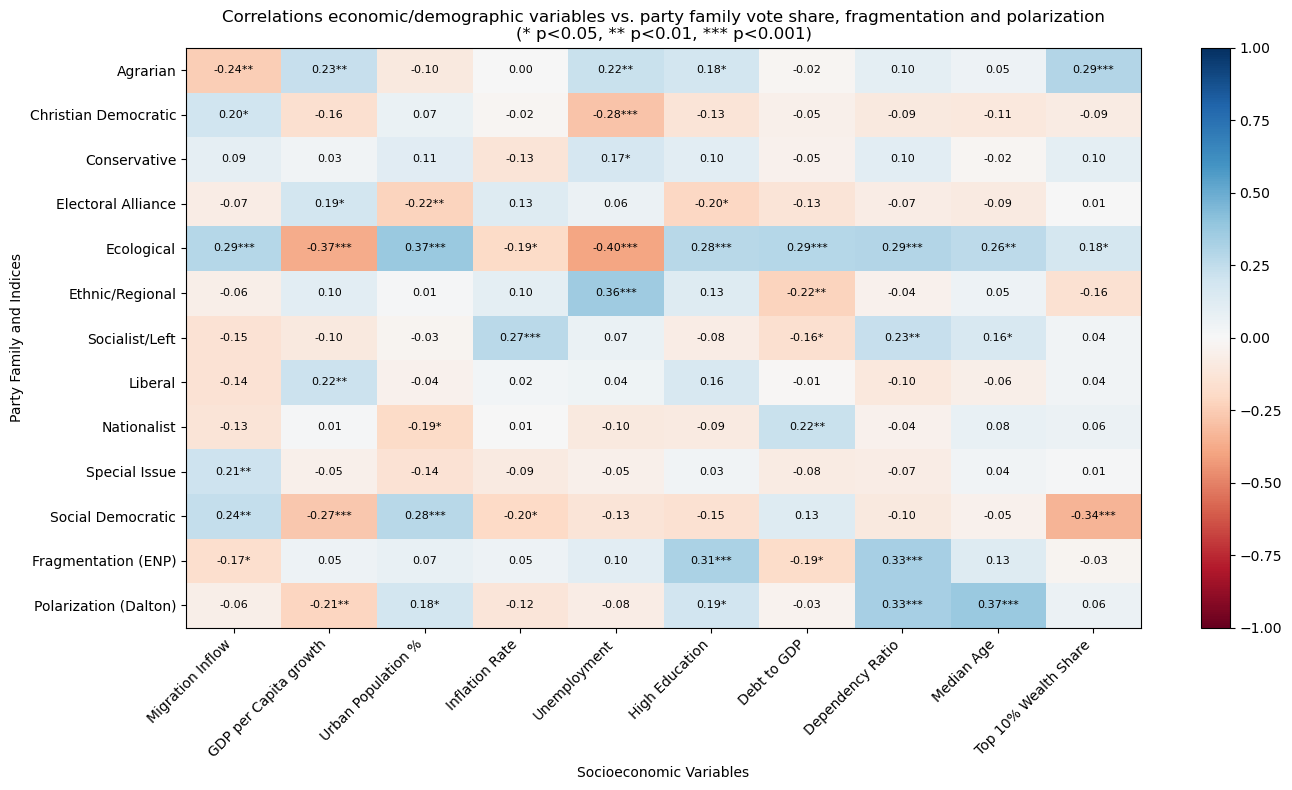

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Party family vote share columns
vs_cols = [col for col in df_averaged.columns if col.startswith('vs_')] + ['fragmentation_enp', 'polarization_dalton']

# calculate correlations and p-values
corr_matrix = []
pval_matrix = []

for vs_col in vs_cols:
    corr_row = []
    pval_row = []
    for socio_col in socioeco_vars:
        # Drop NaN values for both columns
        valid_data = df_averaged[[vs_col, socio_col]].dropna()
        if len(valid_data) > 2:
            corr, pval = stats.pearsonr(valid_data[vs_col], valid_data[socio_col])
        else:
            corr, pval = np.nan, np.nan
        corr_row.append(corr)
        pval_row.append(pval)
    corr_matrix.append(corr_row)
    pval_matrix.append(pval_row)

corr_df = pd.DataFrame(corr_matrix, index=vs_cols, columns=socioeco_vars)
pval_df = pd.DataFrame(pval_matrix, index=vs_cols, columns=socioeco_vars)

# Labels
parfam_labels = {
    'vs_SOC': 'Social Democratic',
    'vs_LEF': 'Socialist/Left',
    'vs_ECO': 'Ecological',
    'vs_LIB': 'Liberal',
    'vs_CHR': 'Christian Democratic',
    'vs_CON': 'Conservative',
    'vs_NAT': 'Nationalist',
    'vs_AGR': 'Agrarian',
    'vs_ETH': 'Ethnic/Regional',
    'vs_SIP': 'Special Issue',
    'vs_DIV': 'Electoral Alliance',
    'fragmentation_enp': 'Fragmentation (ENP)',
    'polarization_dalton': 'Polarization (Dalton)'
}

var_labels = {
    'poverty_risk': 'Poverty Risk',
    'gdp_per_cap': 'GDP per Capita growth',
    'inflation_rate': 'Inflation Rate',
    'unemployment_rate': 'Unemployment',
    'dependency_ratio_15_64': 'Dependency Ratio',
    'debt_to_gdp': 'Debt to GDP',
    'Tertiary education': 'High Education',
    'rel_immigration': 'Migration Inflow',
    'median_age': 'Median Age',
    'urban_population_pct': 'Urban Population %',
    'wealth_top10_share': 'Top 10% Wealth Share'
}

# Apply labels
corr_df.index = corr_df.index.map(lambda x: parfam_labels.get(x, x))
corr_df.columns = corr_df.columns.map(lambda x: var_labels.get(x, x))
pval_df.index = pval_df.index.map(lambda x: parfam_labels.get(x, x))
pval_df.columns = pval_df.columns.map(lambda x: var_labels.get(x, x))

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(corr_df.values, cmap='RdBu', vmin=-1, vmax=1, aspect='auto')
cbar = plt.colorbar(im)

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))
ax.set_xticklabels(corr_df.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_df.index)

## Add correlation values and significance markers
for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        val = corr_df.iloc[i, j]
        pval = pval_df.iloc[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        
        # Add stars for significance
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = ''
        
        ax.text(j, i, f'{val:.2f}{stars}', ha='center', va='center', color=color, fontsize=8)

ax.set_title('Correlations economic/demographic variables vs. party family vote share, fragmentation and polarization\n(* p<0.05, ** p<0.01, *** p<0.001)')
ax.set_xlabel('Socioeconomic Variables')
ax.set_ylabel('Party Family and Indices')

plt.tight_layout()
plt.show()

**Key findings from heatmap**
- Agrarian parties have strong support in countries with high wealth inequality
- Strong negative correlation between social democracy and wealth inequality (due to social democratic policies?)

- Ecological & Social Democratic parties correlated with GDP growth, unemployment (negative), and urban population, tertiary education (positive). Apparent appeal to well-educated, urban voters in developed economies

- Nationalist parties no significant relationship with migration inflow; strong positive with debt levels (protest votes?)

- Polarization & Fragmentation have ositive relationship with dependency ratio (and median age)
- Aging populations may pressure welfare systems, increasing societal tensions

Next, we look at evidence from multivariate OLS regressions, which allows us to (1) measure estimates of multiple coefficients at once and (2) include country- and year-fixed effects (FE). The latter can be meaningful to understand the effect of fast-changing variables like migration inflow or debt level (e.g., what is the impact of a strong deviation in debt from the country mean on polarization?). The effect of slow-changing variables (median age, level of urbanisation) are more meaningfully interpreted without country FE as they absorb most of the meaningful variation. 

The cell below provides estimates in two separate models: A regression model for the slow-changing independent variables (only accounting for year FE), and a model with country and year FE for fast-changing independent variables. Variables have been normalized to allow direct comparison of the effect sizes, and significance levels are provided.

In [ ]:
# Define which variables are fast vs slow changing
dependent_vars = [col for col in df_averaged.columns if col.startswith('vs_')] + ['fragmentation_enp', 'polarization_dalton']

fast_vars = ['inflation_rate', 'unemployment_rate', 'debt_to_gdp', 'gdp_per_cap', 'rel_immigration']
slow_vars = [var for var in socioeco_vars if var not in fast_vars]

def run_dual_regression(dependent_var):
    clear_output(wait=True)
    
    try:
        reg_data = df_averaged[[dependent_var] + socioeco_vars].dropna().reset_index()
        reg_data['election_year'] = pd.to_datetime(reg_data['target_election']).dt.year
        y = reg_data[dependent_var].astype(float)
        
        dep_label = parfam_labels.get(dependent_var, dependent_var)

        print(f"OLS Regressions: {dep_label}")

  
        # reg 1: fast-changing variables WITH country AND year FE
     

        print(f"MODEL 1: Fast-changing variables (with Country and Year Fixed Effects)")

        
        X_fast = reg_data[fast_vars].copy().astype(float)
        
        # Add country FE
        country_dummies = pd.get_dummies(reg_data['country'], prefix='fe_country', drop_first=True).astype(int)
        
        # Add year FE
        year_dummies = pd.get_dummies(reg_data['election_year'], prefix='fe_year', drop_first=True).astype(int)
        
        X_fast_fe = pd.concat([
            X_fast.reset_index(drop=True), 
            country_dummies.reset_index(drop=True),
            year_dummies.reset_index(drop=True)
        ], axis=1)
        
        # Standardize only the socioeconomic vars
        X_fast_fe[fast_vars] = (X_fast_fe[fast_vars] - X_fast_fe[fast_vars].mean()) / X_fast_fe[fast_vars].std()
        X_fast_fe = sm.add_constant(X_fast_fe)
        
        model_fast = sm.OLS(y, X_fast_fe).fit()
        
        print(f"Observations: {int(model_fast.nobs)}")
        print(f"R-squared: {model_fast.rsquared:.3f}")
        print(f"Adj. R-squared: {model_fast.rsquared_adj:.3f}")
        print(f"\n{'Variable':<45} {'Coef':>10} {'Std Err':>10} {'t':>8} {'P>|t|':>8} {'Sig':>5}")
        print("-" * 90)
        
        for var in fast_vars:
            label = var_labels.get(var, var)
            coef = model_fast.params[var]
            std_err = model_fast.bse[var]
            t_val = model_fast.tvalues[var]
            p_val = model_fast.pvalues[var]
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"{label:<45} {coef:>10.3f} {std_err:>10.3f} {t_val:>8.2f} {p_val:>8.3f} {sig:>5}")
    

        # Reg 2: Slow-chagning variables (only year FE)

        print("\n")
        print(f"MODEL 2: Slow-changing variables (with Year Fixed Effects only)")
 
        
        X_slow = reg_data[slow_vars].copy().astype(float)
        
        # Add year FE only (no country FE)
        year_dummies = pd.get_dummies(reg_data['election_year'], prefix='fe_year', drop_first=True).astype(int)
        X_slow_fe = pd.concat([X_slow.reset_index(drop=True), year_dummies.reset_index(drop=True)], axis=1)
        
        # Standardize only the socioeconomic vars
        X_slow_fe[slow_vars] = (X_slow_fe[slow_vars] - X_slow_fe[slow_vars].mean()) / X_slow_fe[slow_vars].std()
        X_slow_fe = sm.add_constant(X_slow_fe)
        
        model_slow = sm.OLS(y, X_slow_fe).fit()
        
        print(f"Observations: {int(model_slow.nobs)}")
        print(f"R-squared: {model_slow.rsquared:.3f}")
        print(f"Adj. R-squared: {model_slow.rsquared_adj:.3f}")
        print(f"\n{'Variable':<45} {'Coef':>10} {'Std Err':>10} {'t':>8} {'P>|t|':>8} {'Sig':>5}")
        print("-" * 90)
        
        for var in slow_vars:
            label = var_labels.get(var, var)
            coef = model_slow.params[var]
            std_err = model_slow.bse[var]
            t_val = model_slow.tvalues[var]
            p_val = model_slow.pvalues[var]
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"{label:<45} {coef:>10.3f} {std_err:>10.3f} {t_val:>8.2f} {p_val:>8.3f} {sig:>5}")

        
    except Exception as e:
        print(f"ERROR: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()

# Create widget
dropdown = widgets.Dropdown(
    options=[(parfam_labels.get(v, v), v) for v in dependent_vars],
    value=dependent_vars[0],
    description='Dependent:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

output = widgets.interactive_output(run_dual_regression, {'dependent_var': dropdown})
display(dropdown, output)


Dropdown(description='Dependent:', layout=Layout(width='300px'), options=(('Agrarian', 'vs_AGR'), ('Christian …

Output()

**Key findings from multivariate regression**

Fewer variables are significant compared to the correlation heatmap, likely due to multicollinearity among covariates.

- Agrarian parties are positively associated with older population and higher education
- Ecological & social democratic parties are negatively associated with GDP growth, social democratic also negatively with wealth inequality and inflation rate, positively with urban population (echoing the findings from the heatmap)

- Socialist/leftist parties positively associated with inflation, dependency ratio; negative with education level; attractiveness in times of hardship?
- Liberal parties: Positive association with education, debt levels; negative with dependency ratio
- Nationalist parties: No significant relationship with migration or debt, negative decreased with unemployment
- No significant associations for conservative & christian-democratic parties
- Fragmentation associated with many variables, but effect sizes small
- Polarization positively associated with median age

AI tools like Claude where used to inquire only specific aspects of the project, e.g. how to create the interactive elements of our output.  

# Research Question 5: 

## To what extend can future parliamentary compositions be predicted by economic and societal indicators?

## Overview
This part aims to predict the election outcomes using historical information after 1995 from various datasets.
We model two targets: 
 1. **Vote Share:** Percentage of votes received.
 2. **Vote Swing:** Change in the vote share from the last election.

## Methodology 
*   **Feature Engineering:** We use lagged freatures, and for important variables delta and rolling mean to capture historic changes and trends.
*   **Validation:** We use a **Walk-Forward Validation**  to prevent data leakage and recreate forecasting.
*   **Models:** We compare a Persistence Baseline against Random Forest and LightGBM regressors. The other models were discarded as the performed significantly worse.


In [ ]:
PATH_ROOT = Path.cwd().parent
PATH_DF = PATH_ROOT / "data" / "merged_df.csv"

In [ ]:
df_merged = pd.read_csv(PATH_DF, sep=",", parse_dates=["election_date"])
df = df.sort_values(["geo", "party_code", "election_date", "year"]).reset_index(drop=True)
df.head()

### Feature Configuration
We categorize our features to apply appropriate preprocessing:
* **Numeric Lags:** Economic indicators which influence voter sentiment.
* **Log Transforms:** Variables which need normalization 
* **Categorical:** To get the the model to learn party family specific  (e.g., Green parties might behave differently than Conservatives).

In [ ]:
log_cols = [
    "population_total",
    "gdp_per_cap"
    ]

numeric_lag_cols = [
    "vote_share_percent",
    "consumer_prices",
    "f_unemployment",
    "m_unemployment",
    "t_unemployment",
    "dependency_ratio_15_64",
    "debt_to_gdp",
    "total_poverty",
    "migration_inflow",
    "median_age",
    "urban_population_pct",
    "wealth_top10_share",
    "rel_migration", 
    "log_gdp_per_cap",
    "log_population_total"]


categorical_cols = [
    "geo",
    "parfam"]

party_cols = [
    "right_left_position",
    "planned_economy",
    "welfare_state",
    "market_economy",
    "inter_positive",
    "democracy",
    "sustainability_positive"]

In [ ]:
for col in log_cols:
    df[f"log_{col}"] = np.log1p(df[col].clip(lower=0))
    
for col in categorical_cols:
    df[col] = df[col].astype("category")

### Feature Engineering: 
Since elections are time-series events, the most powerful predictors are past performance. We define a custom function to create:
1.  **Lagged Features:** The value of the feature in the *previous* election.
2.  **Delta:** The change of the last two periods.
3.  **Rolling Means (3-period):** An average of the last 3 elections to capture trends and reduce noise from outlier years.
4.  **Vote Swing:** Calculated as $Vote_{current} - Vote_{previous}$. This represents the *momentum* of a party.

In [ ]:
high_impact_cols = ["vote_share_percent", "consumer_prices", "migration_inflow", "log_gdp_per_cap"]


def add_features(df, group_cols, all_cols, impact_cols):
    df = df.copy()
    annual_group = df.groupby(group_cols, observed=True)
    
    # Vote-share Grouping
    is_new_election = df["election_date"] != annual_group["election_date"].shift(1)
    election_subset = df[is_new_election].copy()
    vote_group = election_subset.groupby(group_cols, observed=True)

    for col in [c for c in all_cols if c != "vote_share_percent"]:
       
        df[f"{col}_lag1"] = annual_group[col].shift(1)
        
        if col in impact_cols:
            df[f"{col}_delta_1y"] = df[f"{col}_lag1"] - annual_group[col].shift(2)

   
    col = "vote_share_percent"
    election_subset[f"{col}_lag1"] = vote_group[col].shift(1)
    election_subset[f"{col}_rolling_3elec"] = (
        vote_group[col]
        .shift(1)
        .rolling(window=3, min_periods=1)
        .mean()
    )
    
    # Merge the election-based features back into main dataframe
    cols_to_merge = group_cols + ["election_date", f"{col}_lag1", f"{col}_rolling_3elec"]
    df = df.merge(election_subset[cols_to_merge], on=group_cols + ["election_date"], how="left")
    df["vote_swing"] = df["vote_share_percent"] - df["vote_share_percent_lag1"]
    return df

df_features = add_features(df, ["geo", "party_code"], numeric_lag_cols, high_impact_cols)
df_features.head(20)

In [ ]:
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [15, 31, 50],
    'model__max_depth': [-1, 5, 10],
    'model__min_child_samples': [5, 10, 20] 
}

tscv = TimeSeriesSplit(n_splits=5)

# Part 1: Predicting Absolute Vote Share

### Data Preparation
We drop rows where the previous vote share is missing (e.g., first election) because autoregressive features are our strongest predictors.

### Walk-Forward Validation 
Standard Cross-Validation (K-Fold) is dangerous here because it creates "future leakage".
Instead, we define a **Testing Period of the last 5 years**. We will train on all history prior to a specific year and test on that year, simulating a real forecast.

In [ ]:
df_model = df_features.dropna(subset=["vote_share_percent_lag1"]).copy()

cols_drop = ["country", "party_name", "party_code", "parfam_label", "vote_swing"]

# Drop duplicates based on the specific combination
df_model = df_model.drop_duplicates(
    subset=["geo", "party_code", "election_date"], 
    keep='first'
).drop(columns=cols_drop)

# Define the Testing Period (Last 5 Years)
years = sorted(df_model["year"].unique())
test_years = years[-5:]
tuning_cutoff_year = test_years[0]  

print(f"Tuning on data before: {tuning_cutoff_year}")
print(f"Testing on years: {test_years}")

### Model Pipelines
We construct a machine learning pipeline:
1.  **Preprocessing:** `OrdinalEncoder` converts categorical text (like 'Austria') into numbers the model can use.
2.  **Imputation:** `SimpleImputer` fills missing economic data with medians, ensuring the model doesn't crash on patchy data.
3.  **Regressors:**
    * **Random Forest:** Good at capturing complex, non-linear interactions without heavy tuning.
    * **LightGBM:** A gradient boosting model that is generally faster and often more accurate for tabular data.

We perform a **Grid Search** on the LightGBM model to find the best `learning_rate` and tree depth.

In [ ]:
target_col = "vote_share_percent"
engineered_features = [c for c in df_model.columns if "_lag" in c or "_delta" in c or "_rolling_3" in c or "log_" in c]
all_features = engineered_features + categorical_cols + party_cols + ["year"]

df_sorted = df_model.sort_values("election_date")
X = df_sorted[all_features]
y = df_sorted[target_col]

# Split Data for Tuning
mask_tuning = df_sorted["year"] < tuning_cutoff_year

X_tuning = X[mask_tuning]
y_tuning = y[mask_tuning]

In [ ]:
# Absolute Pipeline
sklearn.set_config(transform_output="pandas")
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ], 
    remainder='passthrough' 
)

def get_pipeline(model):
    return Pipeline([
        ("prep", preprocessor),
        ("impute", SimpleImputer(strategy='median')), # Ensures no NAs reach RF
        ("model", model)
    ])

rf_pipeline_share = get_pipeline(RandomForestRegressor(n_estimators=400, max_depth=6, random_state=42, n_jobs=-1))
lgbm_pipeline_share = get_pipeline(LGBMRegressor(random_state=42, verbose=-1))


In [ ]:
grid_search = GridSearchCV(
    estimator=lgbm_pipeline_share,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    refit=False,
    n_jobs=-1,
    verbose=0
)

# Fit Grid Search
grid_search.fit(X_tuning, y_tuning)

# Final parameters used
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")


In [ ]:
# Apply best_params to the pipeline
lgbm_pipeline_share.set_params(**best_params)

### Walk-Forward Evaluation
We iterate through the test years and evaluate three approaches:
1.  **Baseline:** Persistence model. We predict the party will get the same share as the last election.
2.  **Random Forest:** Trained on all data prior to the test year.
3.  **LightGBM (Tuned):** Trained on all data prior to the test year.

**Success Metric:** We look for models with a lower **MAE** and **RMSE** than the Baseline. If our model beats the baseline, it means our economic/social features are explaining changes.

In [ ]:
results = []

for test_year in test_years:
    train_mask = df_sorted["year"] < test_year
    test_mask = df_sorted["year"] == test_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Get Results of baseline 
    baseline_mae = mean_absolute_error(y_test, X_test["vote_share_percent_lag1"])
    baseline_rmse = np.sqrt(mean_squared_error(y_test, X_test["vote_share_percent_lag1"]))
    results.append({
        "model": "Baseline", 
        "test_year": test_year, 
        "MAE": baseline_mae, 
        "RMSE": baseline_rmse
    })

    # RandomForest fit and results
    rf_pipeline_share.fit(X_train, y_train)
    rf_preds = np.clip(rf_pipeline_share.predict(X_test), 0, 100)
    
    rf_mae = mean_absolute_error(y_test, rf_preds)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    results.append({
        "model": "RandomForest", 
        "test_year": test_year, 
        "MAE": rf_mae, 
        "RMSE": rf_rmse
    })

    # LightGBM fit and results
    lgbm_pipeline_share.fit(X_train, y_train)
    lgbm_preds = np.clip(lgbm_pipeline_share.predict(X_test), 0, 100)
    
    lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
    lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_preds))
    results.append({
        "model": "LightGBM (Tuned)", 
        "test_year": test_year, 
        "MAE": lgbm_mae, 
        "RMSE": lgbm_rmse
    })

# Summary Output
results_df = pd.DataFrame(results)

# Get best results 
summary = results_df.groupby("model")[["MAE", "RMSE"]].mean().sort_values("MAE")

print("\n Performance Summary")
print(summary)

# Part 2: Predicting Vote Swing

Because of the results in the Absolute Votes Prediction we added another target, as the votes shares are often dominated by the voters that always make the same choice.
**Swing** tries to isolate the *volatility*. Predicting swing allows us to capture the *direction* of public sentiment shifts driven by current events.

We repeat the feature engineering and cleaning process, specifically targeting the `vote_swing` variable.

In [ ]:
df_proc = df_features.dropna(subset=["vote_swing"])

cols_drop = ["country", "party_name", "party_code", "parfam_label"]

# Drop duplicates based on the specific combination
df_proc = df_proc.drop_duplicates(
    subset=["geo", "party_code", "election_date"], 
    keep='first'
).drop(columns=cols_drop)

# Define the Testing Period (Last 5 Years)
years = sorted(df_proc["year"].unique())
test_years = years[-5:]
tuning_cutoff_year = test_years[0]  

print(f"Tuning on data before: {tuning_cutoff_year}")
print(f"Testing on years: {test_years}")


In [ ]:
target_col_swing = "vote_swing"
engineered_features = [c for c in df_proc.columns if any(s in c for s in ["_lag", "_rolling_3", "_delta", "log_"])]
all_features = engineered_features + categorical_cols + party_cols + ["year"]

df_sorted_swing = df_proc.sort_values("election_date")
X_swing = df_sorted_swing[all_features]
y_swing = df_sorted_swing[target_col_swing] 
#y_actual = df_sorted_swing[target_col] 

# Split Data for Tuning 
mask_tuning = df_sorted_swing["year"] < tuning_cutoff_year
X_tuning_swing = X_swing[mask_tuning]
y_tuning_swing = y_swing[mask_tuning]


### Tuning the Swing Model
Swing is a noisier target than absolute share. Thats why we re-tune our LightGBM model specifically for this distribution.

In [ ]:
# Swing models pipeline
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
], remainder='passthrough')

def get_pipeline(model):
    return Pipeline([
        ("prep", preprocessor),
        ("impute", SimpleImputer(strategy='median')),
        ("model", model)
    ])

rf_pipeline_swing = get_pipeline(RandomForestRegressor(n_estimators=400, max_depth=6, random_state=42))
lgbm_pipeline_swing = get_pipeline(LGBMRegressor(n_estimators=500, learning_rate=0.03, random_state=42, verbose=-1))


In [ ]:
grid_search_swing = GridSearchCV(
    estimator=lgbm_pipeline_swing,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    refit=False,
    n_jobs=-1,
    verbose=0
)

# Fit Grid Search
grid_search_swing.fit(X_tuning_swing, y_tuning_swing)

# Final parameters used
best_params_swing = grid_search_swing.best_params_
print(f"Best parameters found: {best_params_swing}")


In [ ]:
# Apply best_params to the pipeline
lgbm_pipeline_swing.set_params(**best_params_swing)

## Swing evaluation
Walk-forward by test year: train on prior years, compare a persistence baseline (last vote share) to RF and LightGBM swing models that add predicted swing back to the last result.

In [ ]:
# Swing evaluation loop
results_swing = []

for test_year in test_years:
    train_mask = df_sorted_swing["year"] < test_year
    test_mask = df_sorted_swing["year"] == test_year

    X_train_swing, y_train_swing = X_swing[train_mask], y_swing[train_mask]
    X_test_swing, y_test_swing = X_swing[test_mask], y_swing[test_mask]

    # Baseline 
    # The baseline for swing is predicting 0 
    baseline_preds_swing = np.zeros(len(y_test_swing))
    
    baseline_mae = mean_absolute_error(y_test_swing, baseline_preds_swing)
    baseline_rmse = np.sqrt(mean_squared_error(y_test_swing, baseline_preds_swing))
    results_swing.append({
        "model": "Baseline", 
        "test_year": test_year, 
        "MAE": baseline_mae, 
        "RMSE": baseline_rmse
    })

    # RandomForest
    rf_pipeline_swing.fit(X_train_swing, y_train_swing)
    rf_preds_swing = np.clip(rf_pipeline_swing.predict(X_test_swing), -50, 50)
    
    rf_mae = mean_absolute_error(y_test_swing, rf_preds_swing)
    rf_rmse = np.sqrt(mean_squared_error(y_test_swing, rf_preds_swing))
    results_swing.append({
        "model": "RandomForest", 
        "test_year": test_year, 
        "MAE": rf_mae, 
        "RMSE": rf_rmse
    })

    #  LightGBM 
    lgbm_pipeline_swing.fit(X_train_swing, y_train_swing)
    lgbm_preds_swing = np.clip(lgbm_pipeline_swing.predict(X_test_swing), -50, 50)
    
    lgbm_mae = mean_absolute_error(y_test_swing, lgbm_preds_swing)
    lgbm_rmse = np.sqrt(mean_squared_error(y_test_swing, lgbm_preds_swing))
    results_swing.append({
        "model": "LightGBM (Tuned)", 
        "test_year": test_year, 
        "MAE": lgbm_mae, 
        "RMSE": lgbm_rmse
    })

# Summary Output
results_df_swing = pd.DataFrame(results_swing)

# Get best results 
summary_swing = results_df_swing.groupby("model")[["MAE", "RMSE"]].mean().sort_values("MAE")

print("\n--- Swing Model Performance Summary ---")
print(summary_swing)

### Feature Importance Analysis
Finally, we visualize what drives our models.
* **Autoregression:** For the Absolute model, `vote_share_lag1` will likely be the dominant feature (past predicts future).
* **Macro Drivers:** For the Swing model, we look for features like `consumer_prices_delta` (inflation change) or `migration_inflow`. These tell us why a party gained or lost votes, moving beyond simple history.

In [ ]:

def plot_pipeline_importance(pipeline, title="Feature Importance"):
    model = pipeline.steps[-1][1]
    
    try:
        feature_names = pipeline.named_steps['prep'].get_feature_names_out()
    except:
        feature_names = all_features 

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return

    feat_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, len(feat_df)//4 + 2))
    plt.barh(feat_df['feature'], feat_df['importance'], color='skyblue')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
# Absolute vote share
plot_pipeline_importance(rf_pipeline_share, title="Random Forest: Absolute Vote Share Drivers")
plot_pipeline_importance(lgbm_pipeline_share, title="LightGBM: Absolute Vote Share Drivers")

# Swing share
plot_pipeline_importance(rf_pipeline_swing, title="Random Forest: Swing Model Importances")
plot_pipeline_importance(lgbm_pipeline_swing, title="LightGBM: Swing Model Importances")


## Key Findings
1.  In both Absolute Share and Swing models, the Persistence Baseline outperformed the machine learning models. The Baseline achieved an MAE of ~3.07, while the best ML model (LightGBM) lagged behind at ~3.31.

2. The plots show that the previous election result is the most powerful predictor. Macro-economic indicators like GDP growth and inflation, are relevant, but show significantly lower prediction power.

3. The Swing Model showed more adaptability, which suggests that ML is better suited for predicting movement rather than levels in vote prediction.

### Analysis
The underperformance of the ML models to the baseline highlights two main factors:

1. The Voter behavior in the dataset is quite stable. Most economic factors only affects a small margin of swing voters, making it hard for models to justify changing the prediction from the previous result without causing higher errors.

2. Out current models still lack Context. Economic growth typically rewards the party in power but does not affect opposition parties the same way. Without an "in-government" flag, the models likely treat economic growth as a universal benefit, which is theoretically and empirically incorrect. 

### Future Improvements
To surpass the persistence baseline, future iterations should:

* Add Interaction Terms: Link economic performance to the Incumbent Party.
* Incorporate Polling: Add the most recent poll data as a feature to capture short-term shifts.
* Normalization: Constrain predictions to ensure party shares sum to 100% per election.